In [1]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import pandas as pd 
import matplotlib.pyplot as plt      
import torch
import seaborn as sns

# Necessary functions to preprocess the data, get the features and plot them


In [2]:
# initial dataframe
def pre_process(data_path,timestamps=None,normalize=False):
    data=pd.read_excel(data_path)
    # print("The RAW DATA info is:")
    # data.info()

    #preprocessing to get it in my order
    df=data.copy() #copying it so original data is not affected
    df=df.dropna()
    df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
    df=df.rename({
        "Time - Current":"Time",
        "Current (kA) - Current":"Current (kA)",
        "Voltage (V) - Voltage":"Voltage (V)",
        "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
        "Force (kg) - Force":"Force (kgf)"
    },axis=1)

    if normalize:
        df=(df-df.mean())/df.std()
        return df
    elif timestamps is not None:
        df=df.loc[timestamps]
        return df
    else:
        return df
    # print("\n the formatted data info is: ")
    # df.info()

In [3]:

def get_features(sensor,timestamps=None,spotf=1,spotl=69,normalize=False):
    feature_list={'mean':[],
                'median':[],
                'mode':[],
                'std':[],
                'max':[],
                "min":[],
                # "skew":[],
                # "kurt":[],
                "q_25":[],
                "q_50":[],
                "q_75":[],
                # "cov":[],
                "peaks":[]
                }
    for i in range(spotf,spotl,1):
        data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
        df=pre_process(data_path,timestamps=timestamps,normalize=normalize)
        signal=np.array(df[sensor])
        signal_norm=(signal-np.mean(signal))/np.std(signal)

        feature_list["mean"].append(np.round(np.mean(signal),4))
        feature_list['median'].append(np.round(np.median(signal),4))
        feature_list['mode'].append(np.round(stats.mode(signal, keepdims=True)[0][0],4))
        feature_list['std'].append(np.round(np.std(signal),4))
        feature_list['max'].append(np.round(np.max(signal),4))
        feature_list['min'].append(np.round(np.min(signal),4))
        # feature_list['skew'].append(np.round(stats.skew(signal),4))
        # feature_list['kurt'].append(np.round(stats.kurtosis(signal),4))
        feature_list['q_25'].append(np.round(np.percentile(signal, [25]),4))
        feature_list['q_50'].append(np.round(np.percentile(signal, [50]),4))
        feature_list['q_75'].append(np.round(np.percentile(signal, [75]),4))
        # feature_list['cov'].append(np.round(np.std(signal) / np.mean(signal),4))
        peaks, _ = find_peaks(signal)
        feature_list['peaks'].append(len(peaks))

    return feature_list


In [4]:
def plot_features(dataframe,sensor,features,trend=True,deg=1):
    n_features=len(dataframe.columns)
    n_cols=1
    n_rows=-(-n_features//n_cols)

    fig, axes= plt.subplots(n_rows,n_cols, figsize=(60,15*n_rows))
    axes=axes.flatten()
    plt.suptitle(f"Extracted features of {sensor}",fontsize=16)

    for i, feature in enumerate(features):
        axes[i].plot(dataframe.index,dataframe[feature],'o-',label=f'{sensor} {feature}')
        axes[i].set_title(f"{sensor} {feature}")
        axes[i].set_xlabel("Spot No.")
        axes[i].set_ylabel(f"{feature} (Ohm)")
        axes[i].grid(True)
        axes[i].set_xticks(np.arange(1,dataframe.shape[0]+1,1))
        if trend:
            coeffs = np.polyfit(dataframe.index,dataframe[feature] , deg=deg)
            trendline = np.polyval(coeffs, dataframe.index)
            axes[i].plot(dataframe.index, trendline, color='red', label='Linear Trendline',linestyle='dashed')
        axes[i].legend()

    for j in range(i+1,len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Here we can call for features instance and next plot them


In [6]:
timestamps=np.arange(118,613,1)

# extracting all the statistical features for each sensor
feature_list_Resistance=get_features(sensor="Resistance (Ohm)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Force=get_features(sensor="Force (kgf)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Current=get_features(sensor="Current (kA)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Voltage=get_features(sensor='Voltage (V)',spotf=1,spotl=69,normalize=False,timestamps=timestamps)

# creating respective dataframes

df_Resistance=pd.DataFrame(feature_list_Resistance,columns=feature_list_Resistance.keys())
# #normalizing features
# df_Resistance= (df_Resistance - df_Resistance.mean()) / df_Resistance.std()
df_Resistance.index = range(1, len(df_Resistance) + 1)

df_Current=pd.DataFrame(feature_list_Current,columns=feature_list_Current.keys())
# #normalizing features
# df_Current= (df_Current - df_Current.mean()) / df_Current.std()
df_Current.index = range(1, len(df_Current) + 1)

df_Force=pd.DataFrame(feature_list_Force,columns=feature_list_Force.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Force.index = range(1, len(df_Force) + 1)

df_Voltage=pd.DataFrame(feature_list_Voltage,columns=feature_list_Voltage.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Voltage.index = range(1, len(df_Voltage) + 1)




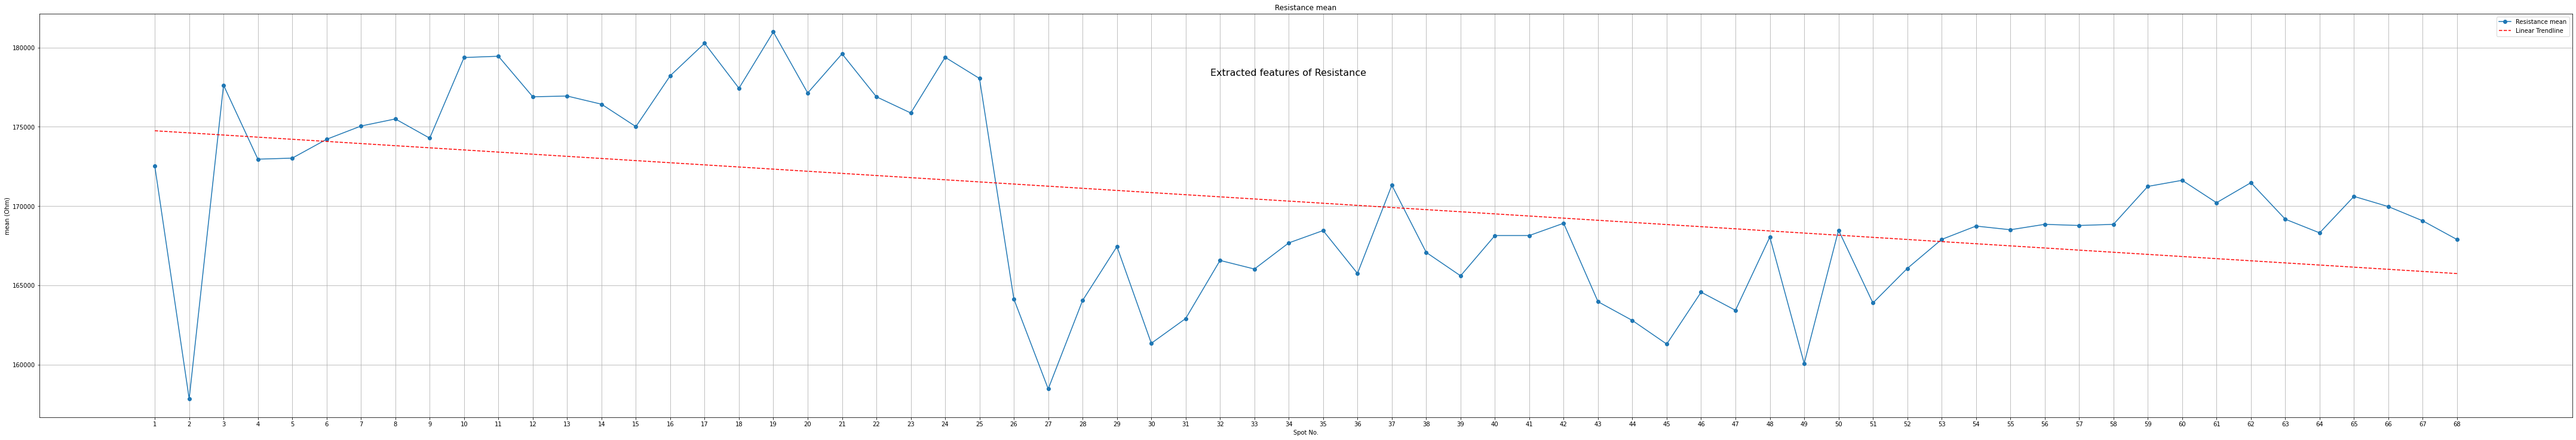

In [98]:
# plotting extracted features for each sensor
plot_features(dataframe=df_Resistance,sensor="Resistance",features=['mean'],trend=True,deg=1)

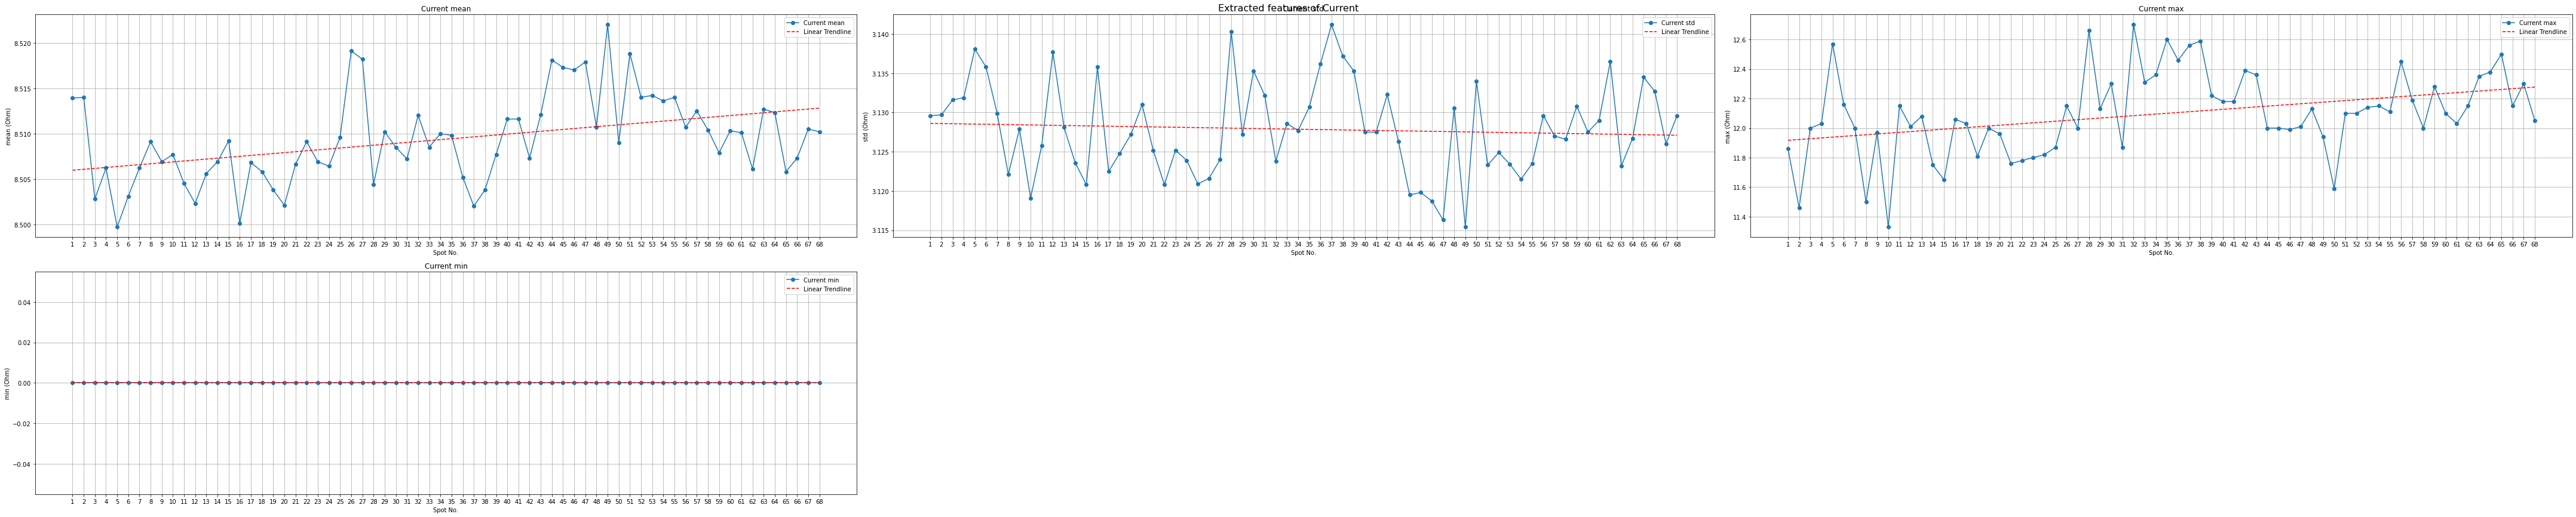

In [7]:
plot_features(dataframe=df_Current,sensor="Current",features=['mean','std','max','min'],trend=True,deg=1)

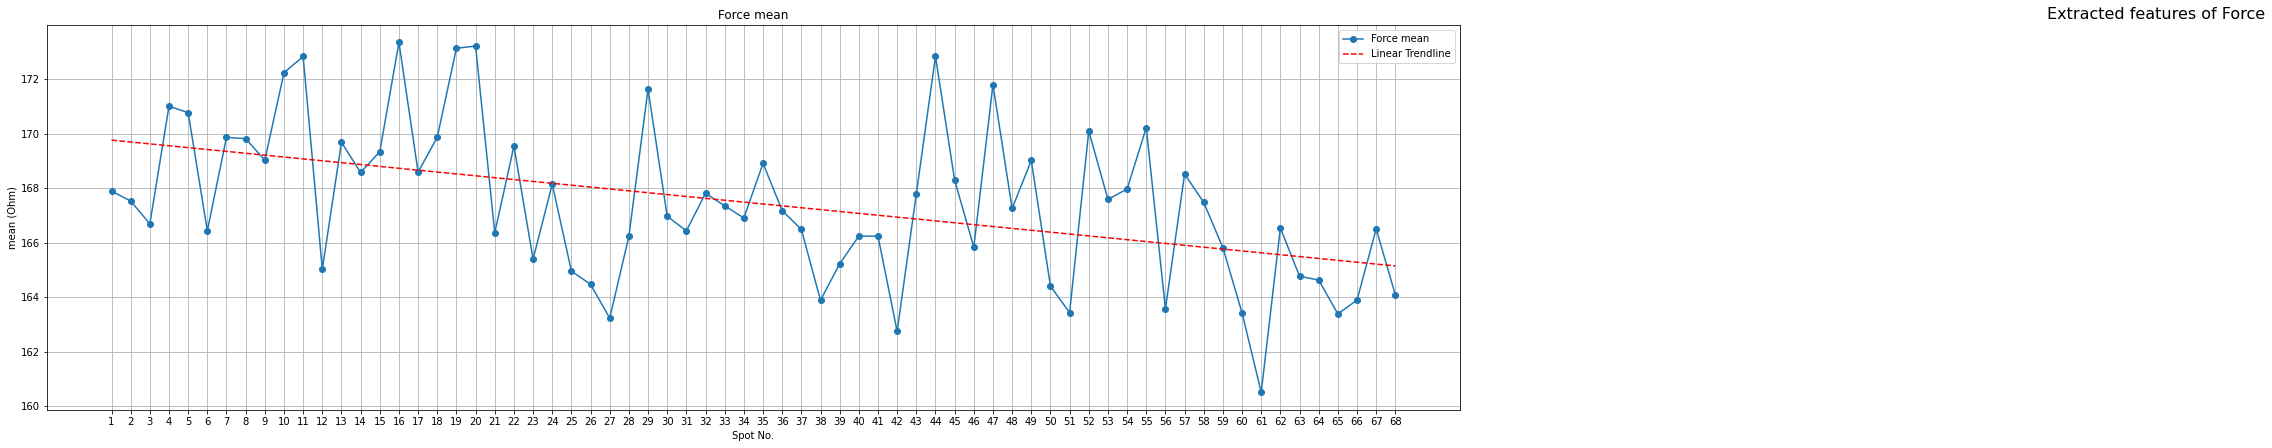

In [52]:
plot_features(dataframe=df_Force,sensor='Force',features=['mean'],trend=True,deg=1)

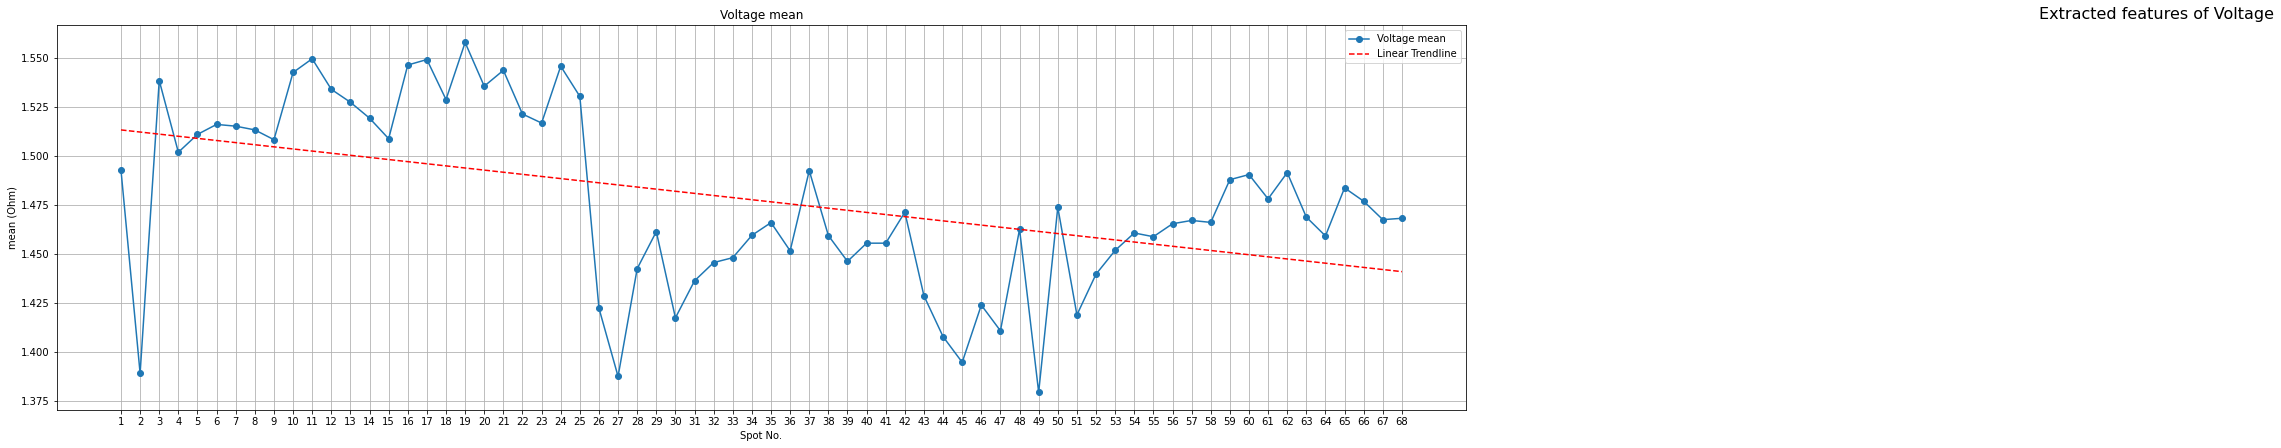

In [53]:
plot_features(dataframe=df_Voltage,sensor='Voltage',features=['mean'],deg=1,trend=True)

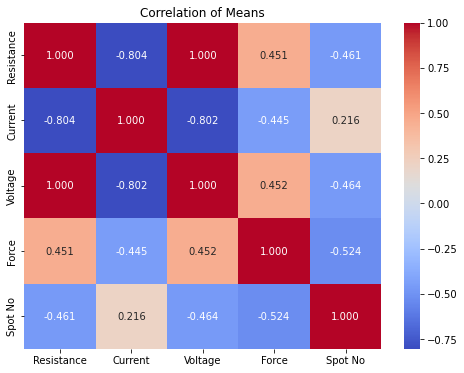

In [103]:
df_combined = pd.DataFrame({
    'Resistance': df_Resistance['mean'],
    'Current': df_Current['mean'],
    'Voltage': df_Voltage['mean'],
    'Force': df_Force['mean'],
    'Spot No' :df_Resistance.index.values
})

# Compute the correlation matrix
corr = df_combined.corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation of Means')
plt.show()

# df_Resistance.index.values

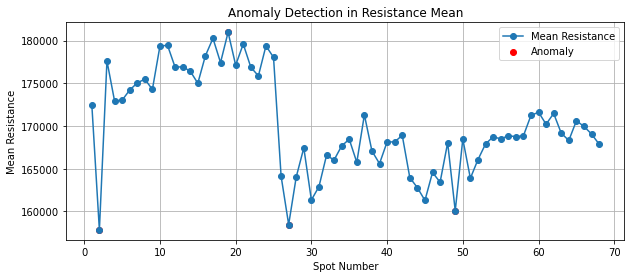

Anomalous spots: [2, 19, 27, 49]


In [105]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

resistance_means=df_Resistance['mean']
spot_numbers=df_Resistance.index.values

X = np.array(resistance_means).reshape(-1, 1)  # Mean resistance

# Train anomaly detector
iso = IsolationForest(contamination=0.05)  # 5% expected anomalies
labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot
plt.figure(figsize=(10, 4))
plt.plot(spot_numbers, resistance_means, marker='o', label='Mean Resistance')
plt.scatter(np.array(spot_numbers)[labels == -1],
            np.array(resistance_means)[labels == -1],
            color='red', label='Anomaly')
plt.xlabel("Spot Number")
plt.ylabel("Mean Resistance")
plt.legend()
plt.title("Anomaly Detection in Resistance Mean")
plt.grid(True)
plt.show()

# Get detected anomalous spots
anomalous_spots = [spot for spot, label in zip(spot_numbers, labels) if label == -1]
print("Anomalous spots:", anomalous_spots)


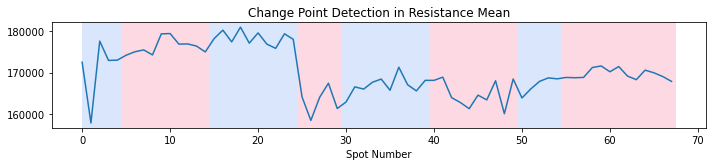

Detected change points at spot indices: [5, 15, 25, 30, 40, 50, 55, 68]


In [109]:
import ruptures as rpt

# Signal = 1D array of mean resistances
signal = np.array(resistance_means)

# Use Pelt or Binary Segmentation
model = "rbf"  # or "l2" depending on data behavior
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=0.25)  # Try tuning 'pen'

# Plot
rpt.display(signal, result)
plt.title("Change Point Detection in Resistance Mean")
plt.xlabel("Spot Number")
plt.show()

# Change points will mark spots where shift occurred
change_points = result
print("Detected change points at spot indices:", change_points)


# Space for rough


In [7]:
data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
data=pd.read_excel(data_path)
# print("The RAW DATA info is:")
# data.info()

#preprocessing to get it in my order
df=data.copy() #copying it so original data is not affected
df=df.dropna()
df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
df=df.rename({
    "Time - Current":"Time",
    "Current (kA) - Current":"Current (kA)",
    "Voltage (V) - Voltage":"Voltage (V)",
    "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
    "Force (kg) - Force":"Force (kgf)"
},axis=1)

Text(0.5, 1.0, 'Spot 1 Voltage Curve')

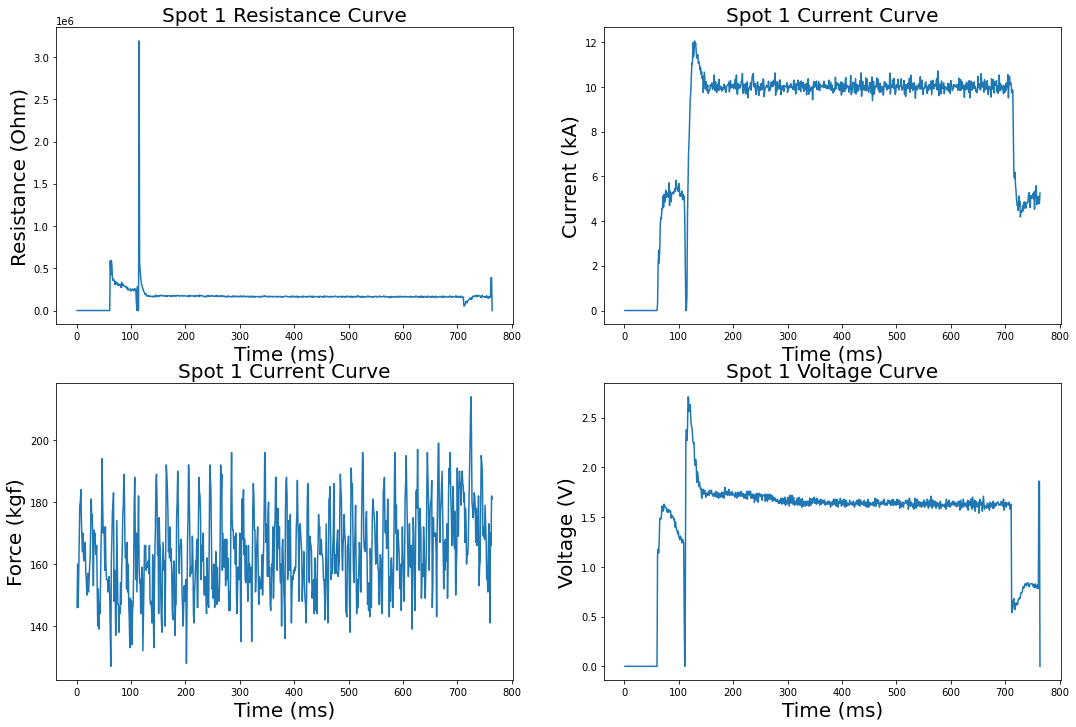

In [7]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(df["Time"],df["Resistance (Ohm)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Spot 1 Resistance Curve",fontsize=20)

plt.subplot(2,2,2)
plt.plot(df["Time"],df["Current (kA)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Current (kA)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,3)
plt.plot(df["Time"],df["Force (kgf)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Force (kgf)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,4)
plt.plot(df["Time"],df["Voltage (V)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Voltage (V)",fontsize=20)
plt.title("Spot 1 Voltage Curve",fontsize=20)

In [82]:
path1=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
path2=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{2}.xlsx"
path3=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{3}.xlsx"
path4=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{4}.xlsx"
path5=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{5}.xlsx"
path6=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{6}.xlsx"
path7=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{7}.xlsx"
path8=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{8}.xlsx"
path9=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{9}.xlsx"
path10=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{10}.xlsx"


path11=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{11}.xlsx"
path24=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{24}.xlsx"
path27=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{27}.xlsx"
path28=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{28}.xlsx"
path34=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{34}.xlsx"
path50=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{50}.xlsx"
path68=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{68}.xlsx"

time=np.arange(66,765,60)
# time=None

df1=pre_process(data_path=path1,timestamps=time)
df2=pre_process(data_path=path2,timestamps=time)
df3=pre_process(data_path=path3,timestamps=time)
df4=pre_process(data_path=path4,timestamps=time)
df5=pre_process(data_path=path5,timestamps=time)
df6=pre_process(data_path=path6,timestamps=time)
df7=pre_process(data_path=path7,timestamps=time)
df8=pre_process(data_path=path8,timestamps=time)
df9=pre_process(data_path=path9,timestamps=time)
df10=pre_process(data_path=path10,timestamps=time)
df11=pre_process(data_path=path11,timestamps=time)
df24=pre_process(data_path=path24,timestamps=time)
df27=pre_process(data_path=path27,timestamps=time)
df28=pre_process(data_path=path28,timestamps=time)
df34=pre_process(data_path=path34,timestamps=time)
df50=pre_process(data_path=path50,timestamps=time)
df68=pre_process(data_path=path68,timestamps=time)







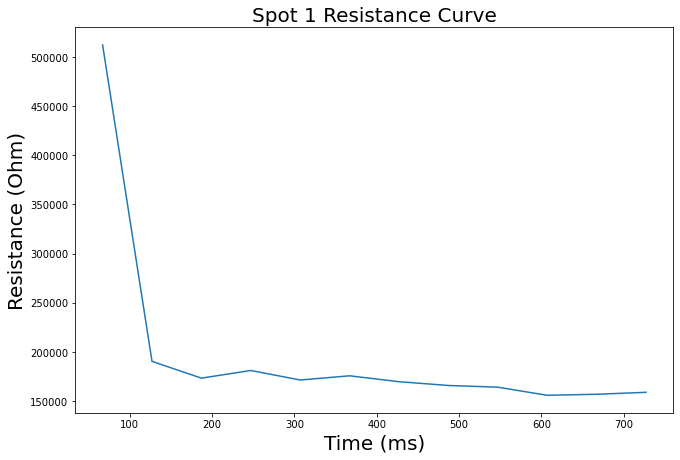

In [83]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(df1["Time"],df1["Resistance (Ohm)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Spot 1 Resistance Curve",fontsize=20)

# plt.subplot(2,2,2)
# plt.plot(df27["Time"],df27["Current (kA)"])
# plt.xlabel("Time (ms)",fontsize=20)
# plt.ylabel("Current (kA)",fontsize=20)
# plt.title("Spot 1 Current Curve",fontsize=20)

# plt.subplot(2,2,3)
# plt.plot(df27["Time"],df27["Force (kgf)"])
# plt.xlabel("Time (ms)",fontsize=20)
# plt.ylabel("Force (kgf)",fontsize=20)
# plt.title("Spot 1 Current Curve",fontsize=20)

# plt.subplot(2,2,4)
# plt.plot(df27["Time"],df27["Voltage (V)"])
# plt.xlabel("Time (ms)",fontsize=20)
# plt.ylabel("Voltage (V)",fontsize=20)
# plt.title("Spot 1 Voltage Curve",fontsize=20)

# plt.subplot(3,3,5)
# plt.plot(df50["Time"],df50["Resistance (Ohm)"])
# plt.xlabel("Time (ms)")
# plt.ylabel("Resistance (Ohm)")
# plt.title("Spot 50 Resistance Curve")

# plt.subplot(3,3,6)
# plt.plot(df67["Time"],df67["Resistance (Ohm)"])
# plt.xlabel("Time (ms)")
# plt.ylabel("Resistance (Ohm)")
# plt.title("Spot 67 Resistance Curve")

plt.tight_layout()
plt.show()



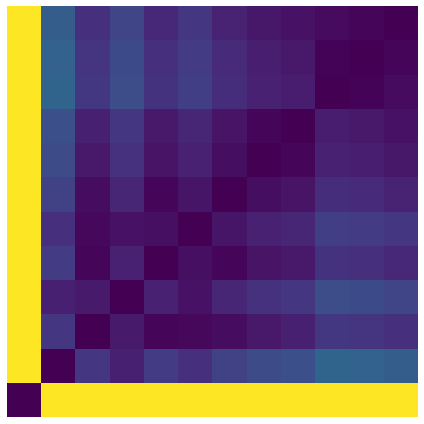

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def get_rp_matrix(signal_values,N=0.3):
    # --- Input: 1D signal from your dataframe ---
    signal = signal_values.values.astype(np.float32)

    # --- Optional: Normalize signal to [0, 1] for better image quality ---
    scaler = MinMaxScaler()
    signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()


    # --- Generate modified recurrence plot ---
    K = len(signal)
    rp_matrix = np.zeros((K, K), dtype=np.float32)

    for i in range(K):
        for j in range(K):
            diff = abs(signal[i] - signal[j])
            rp_matrix[i, j] = N if diff > N else diff

    # --- Optional: Normalize for better image contrast ---
    rp_matrix = (rp_matrix - rp_matrix.min()) / (rp_matrix.max() - rp_matrix.min())

    return rp_matrix

rp_mat=get_rp_matrix(signal_values=df1["Resistance (Ohm)"])
plt.figure(figsize=(6, 6))
plt.imshow(rp_mat, cmap='viridis', origin='lower')
plt.axis('off')
plt.tight_layout()

plt.show()


C:\Users\pavan kumar\AppData\Local\Temp\ipykernel_7136\3447156606.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


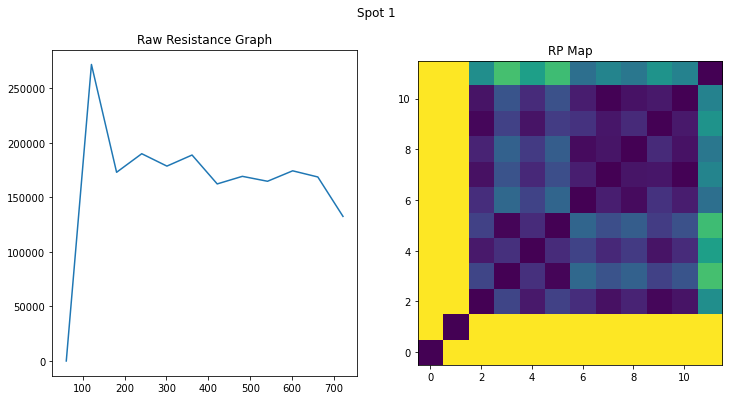

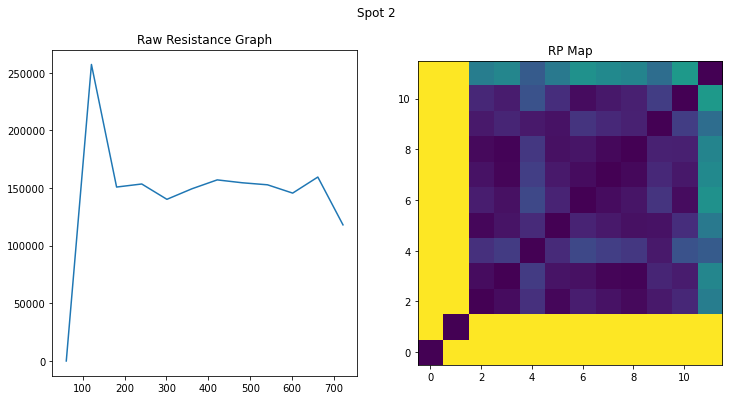

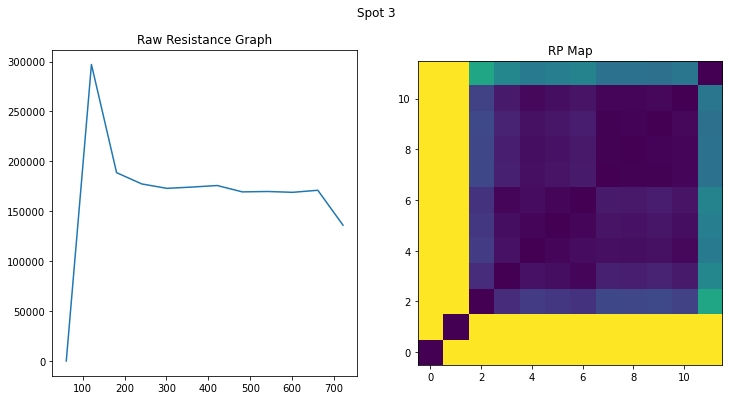

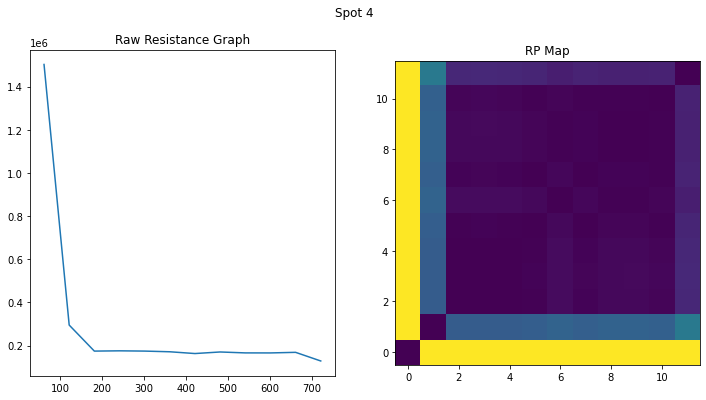

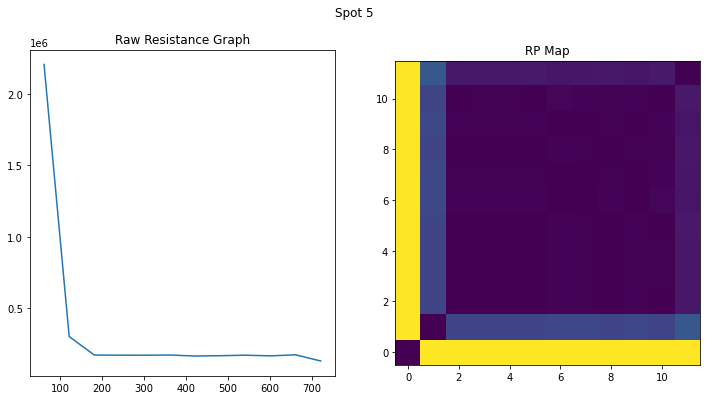

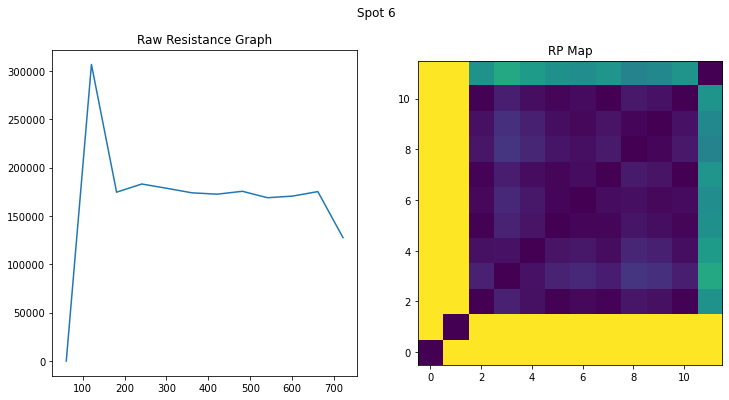

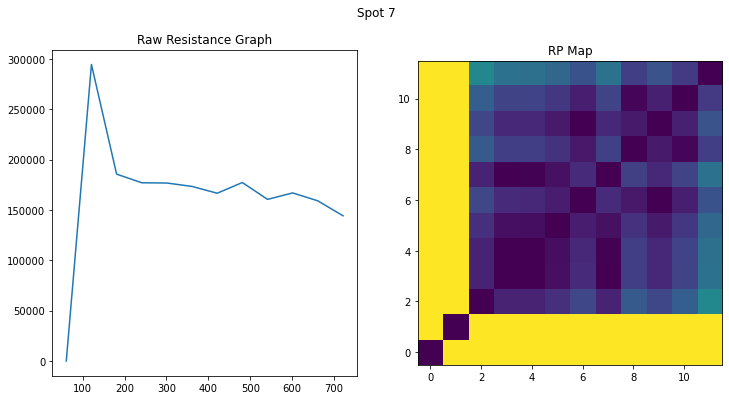

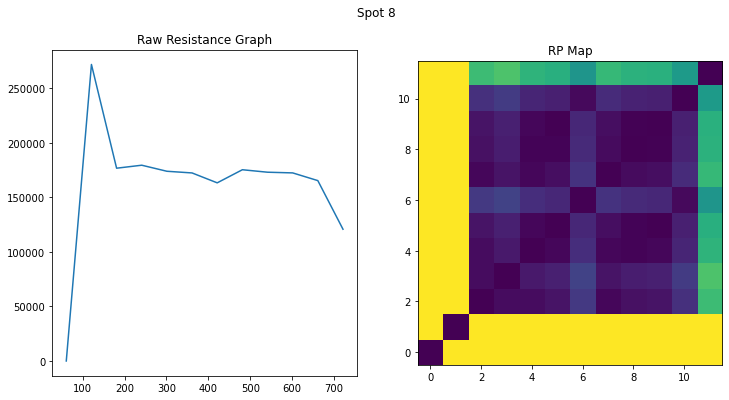

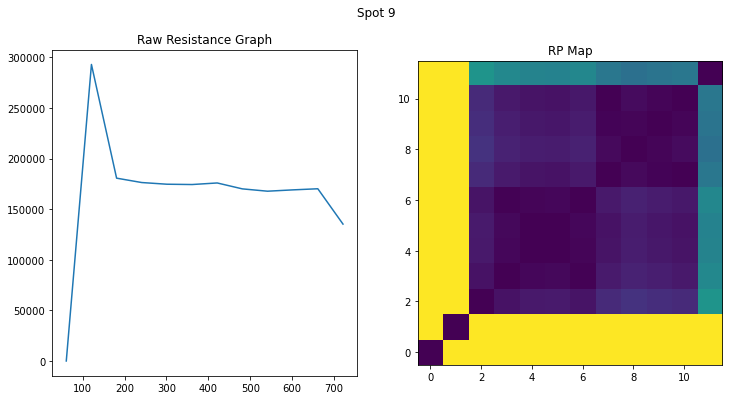

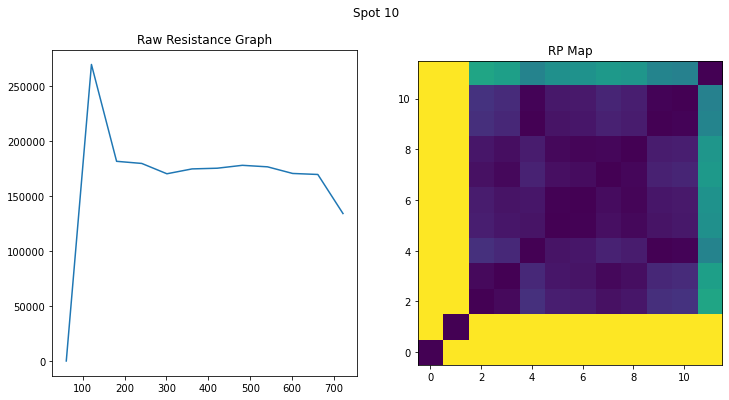

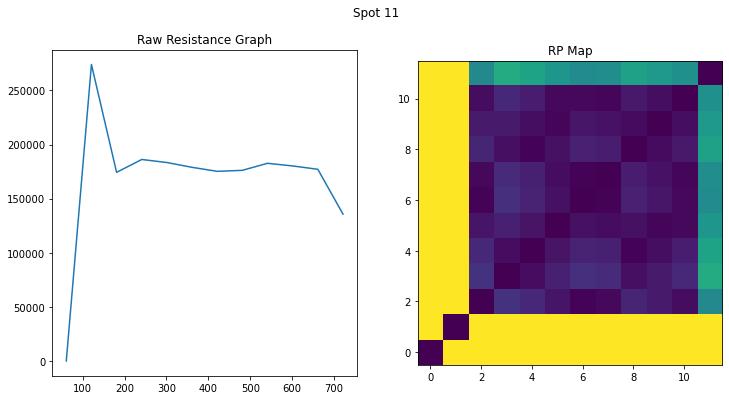

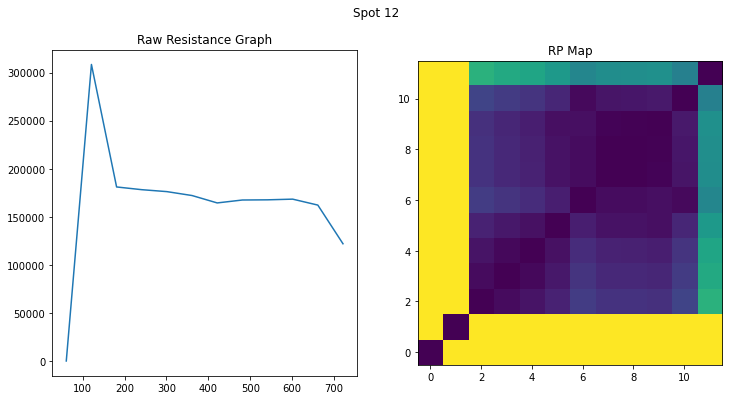

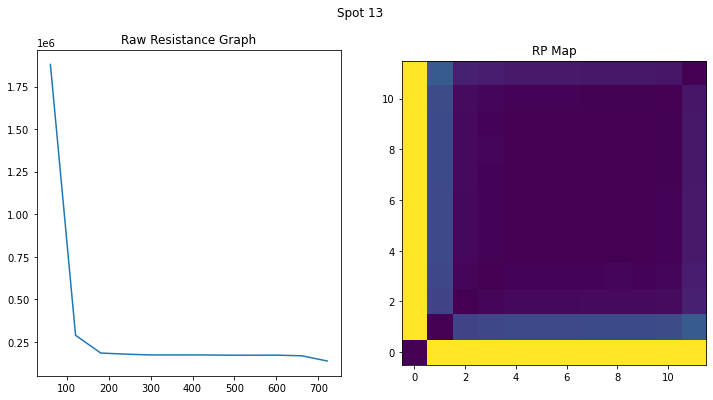

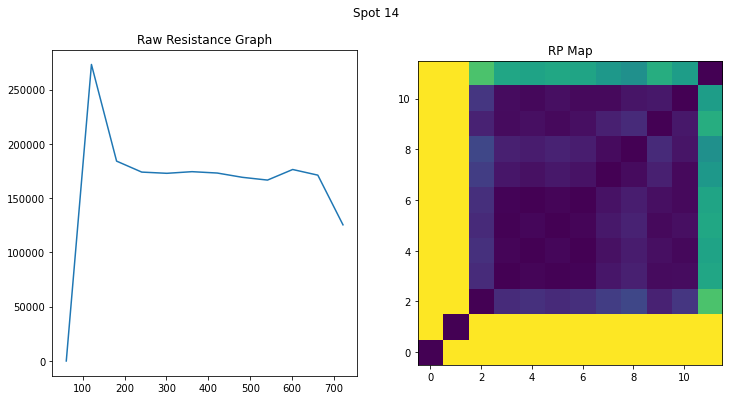

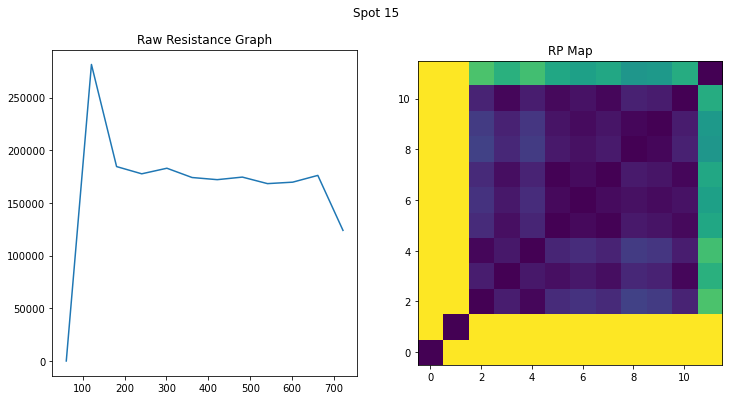

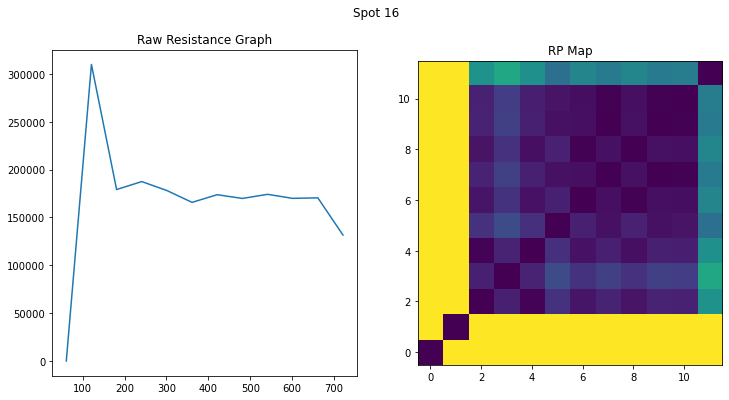

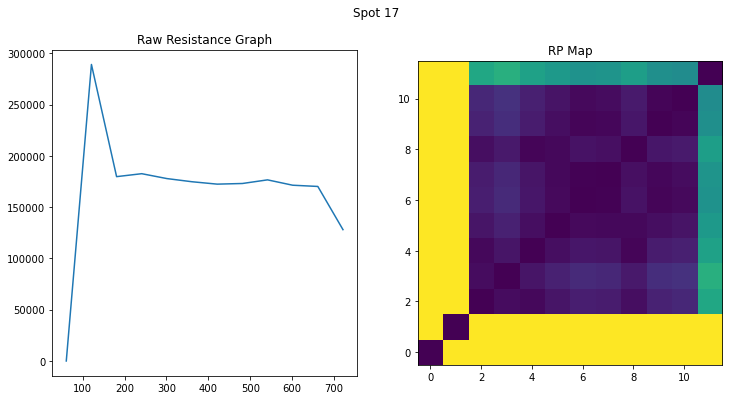

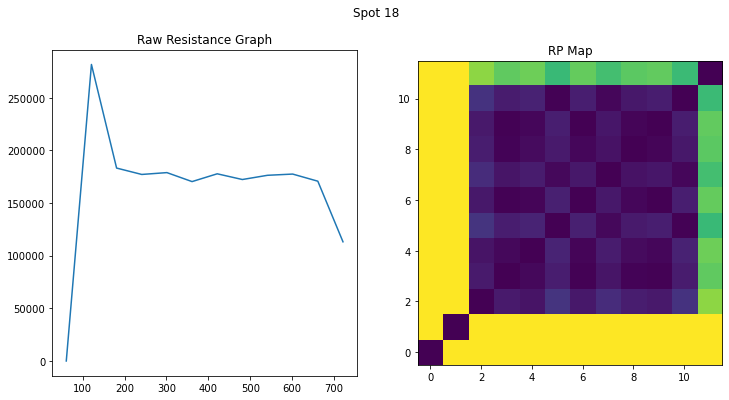

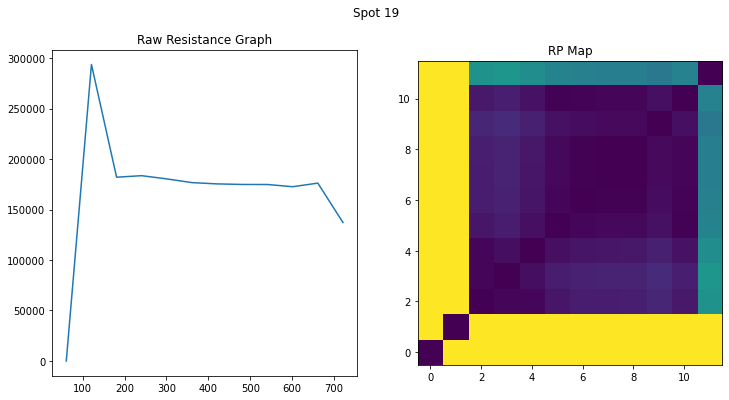

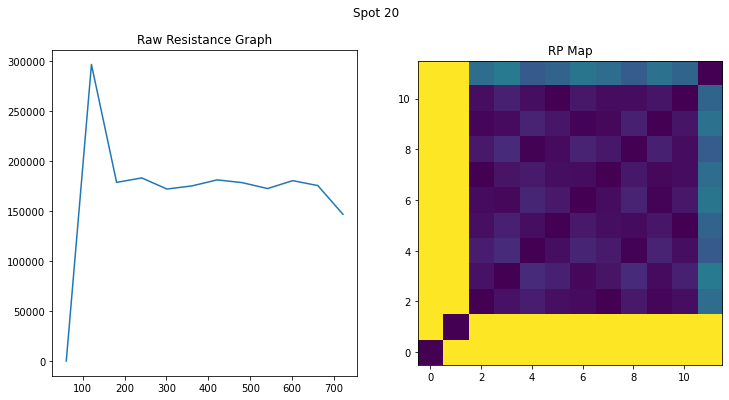

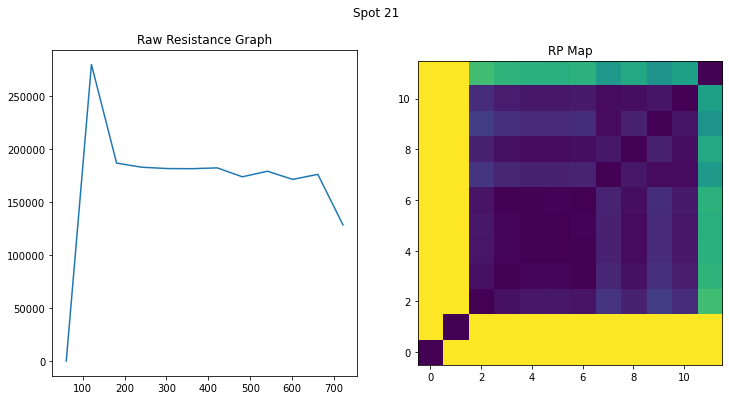

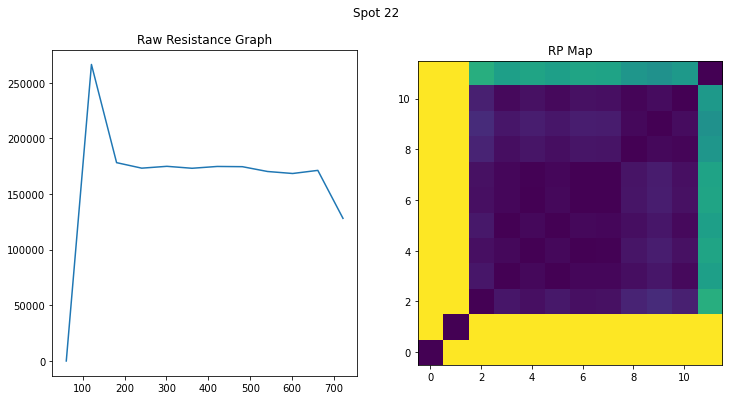

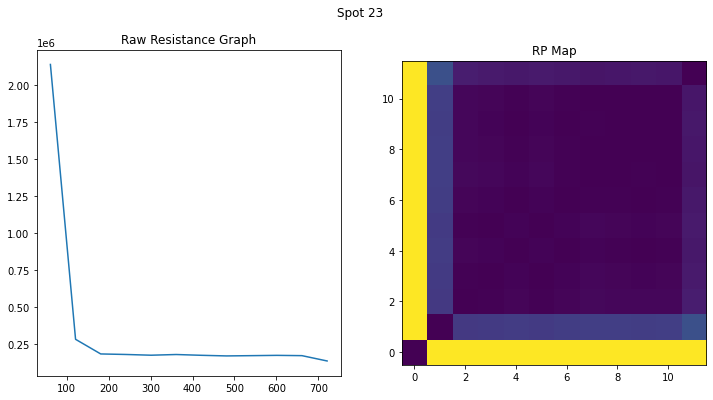

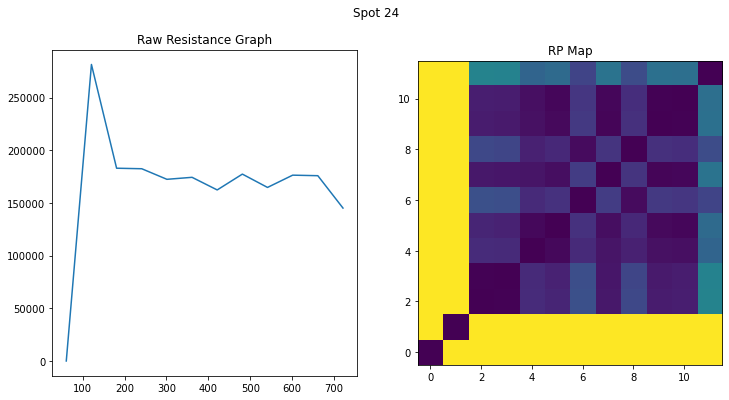

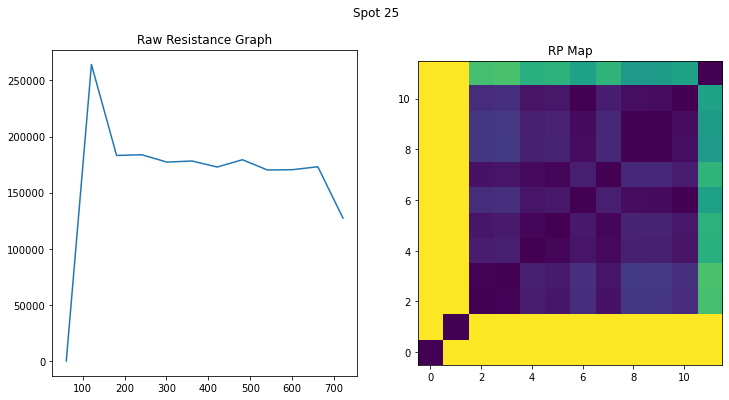

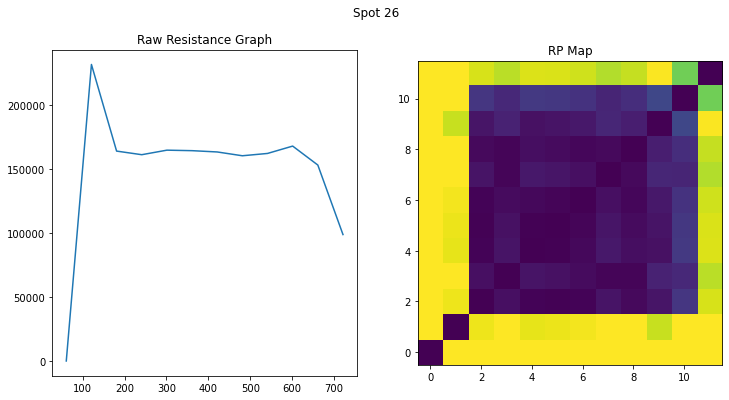

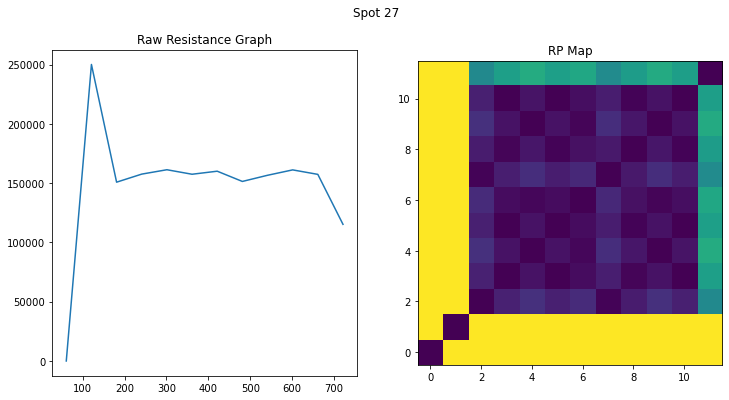

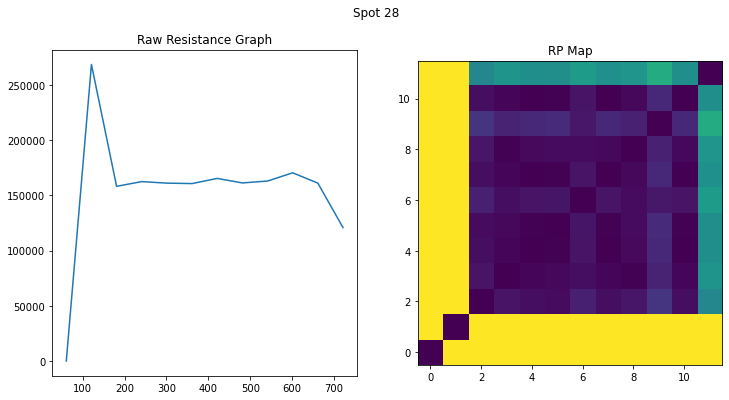

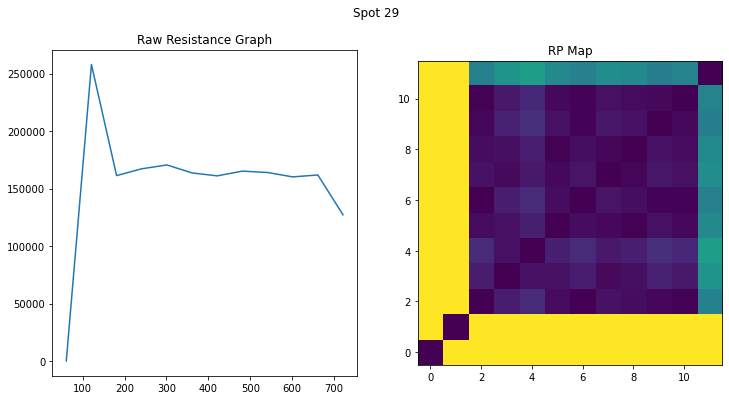

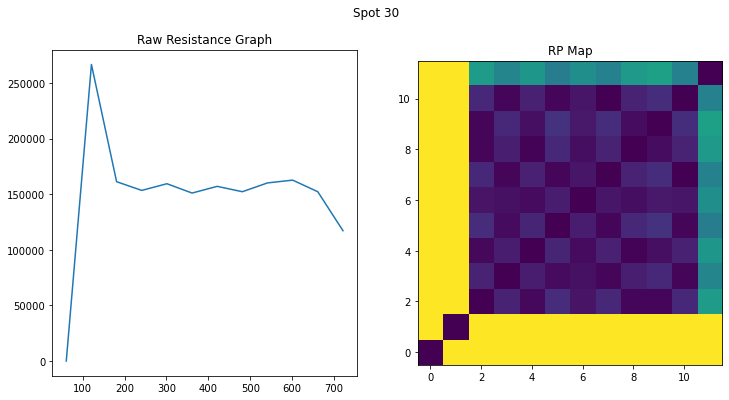

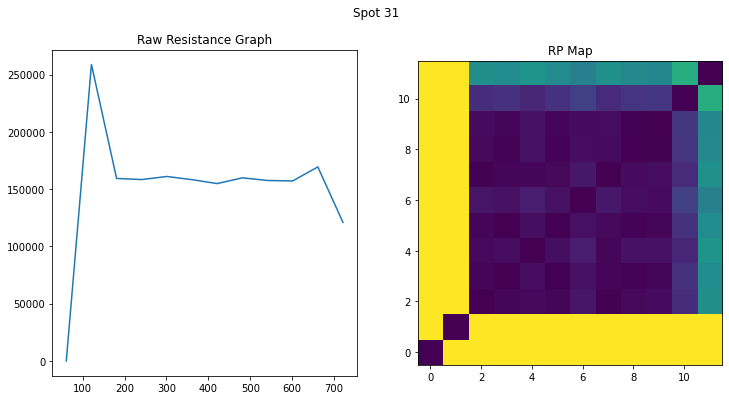

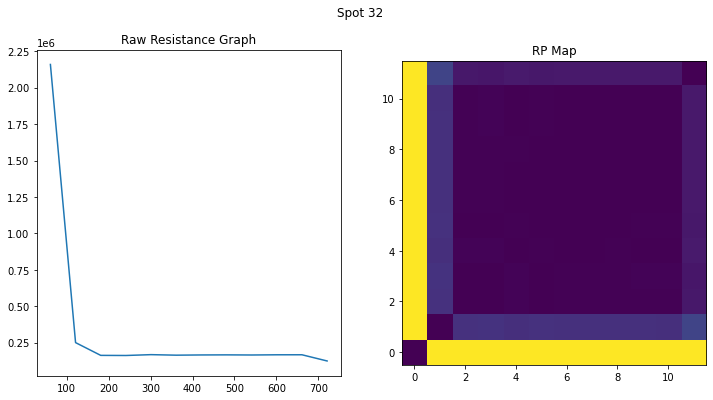

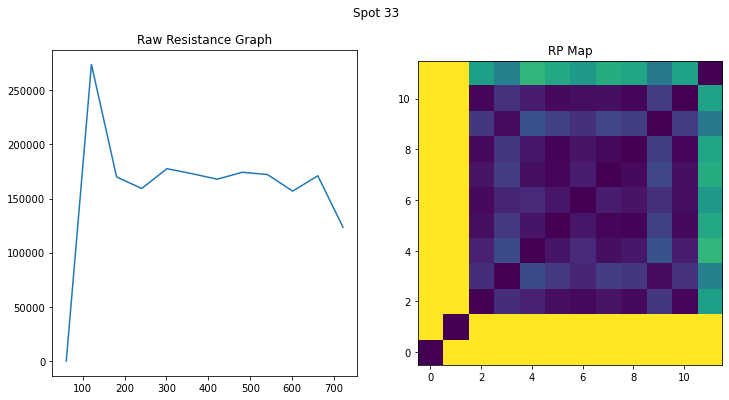

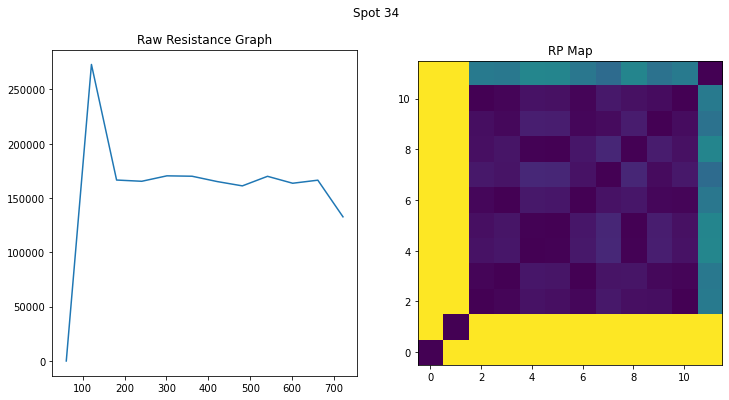

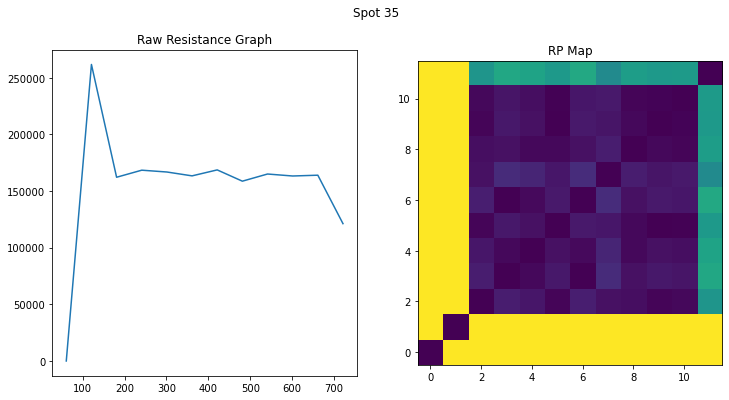

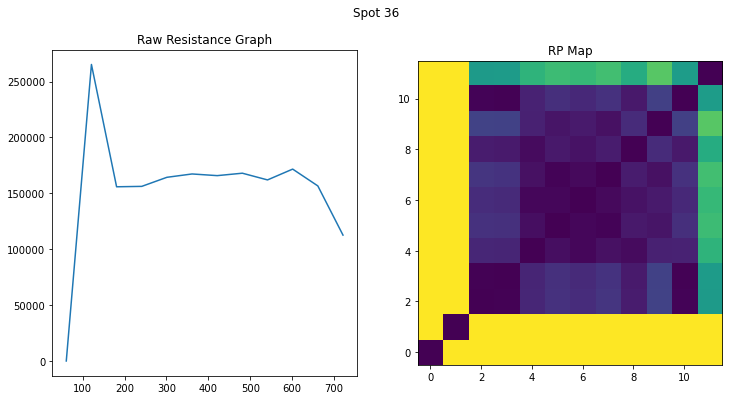

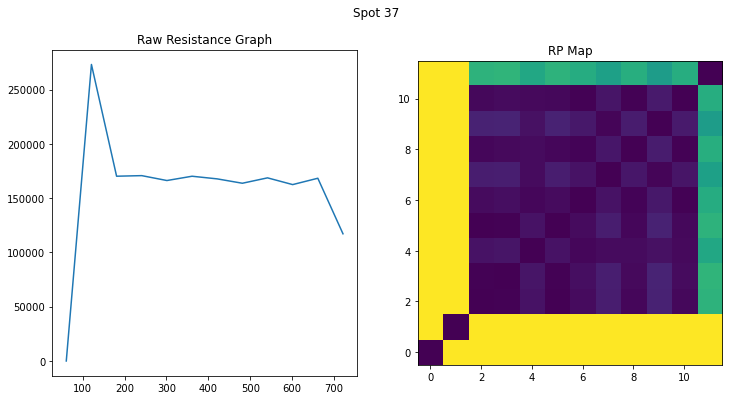

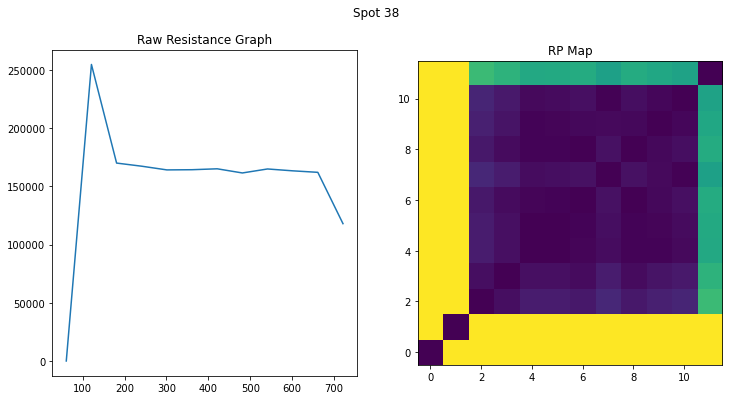

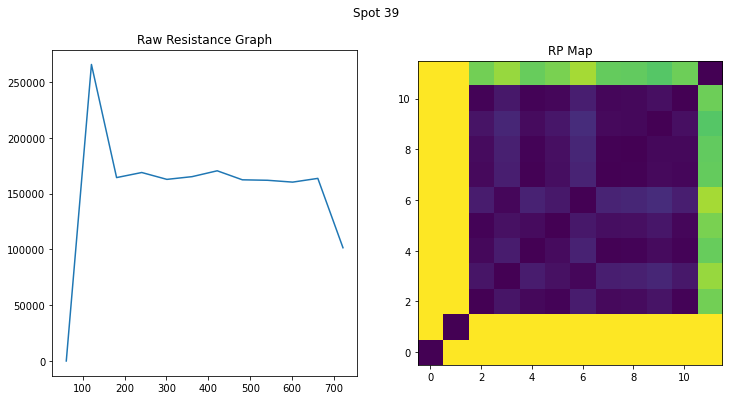

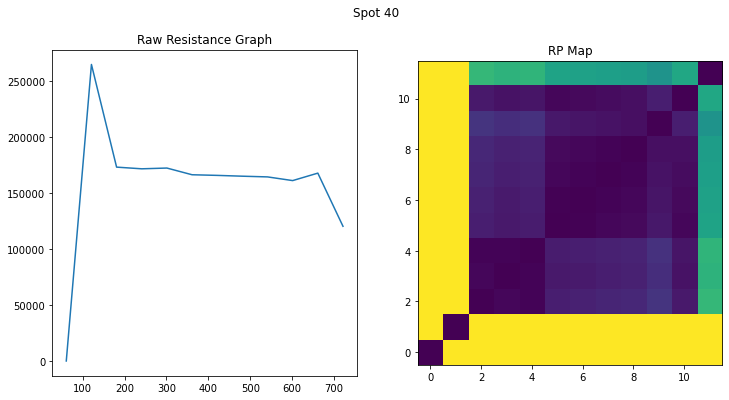

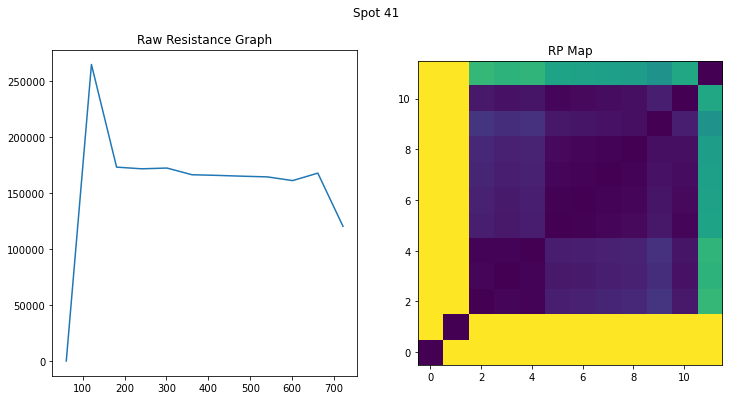

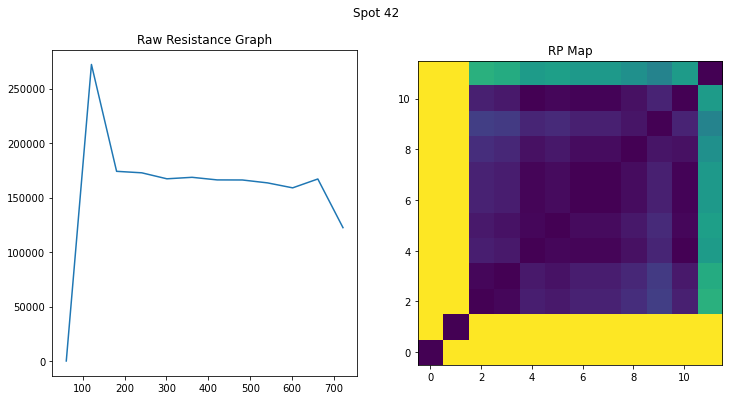

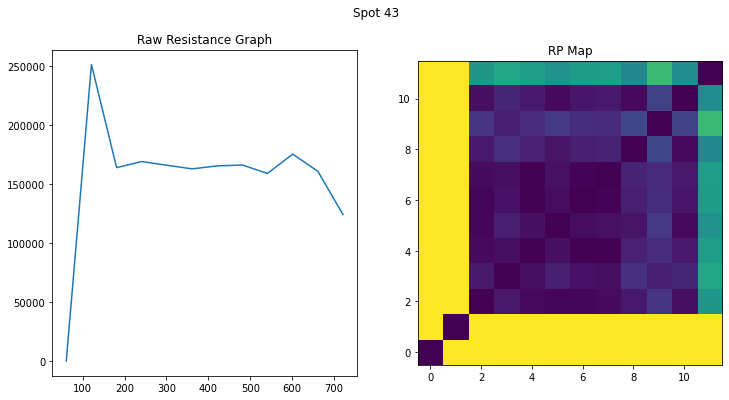

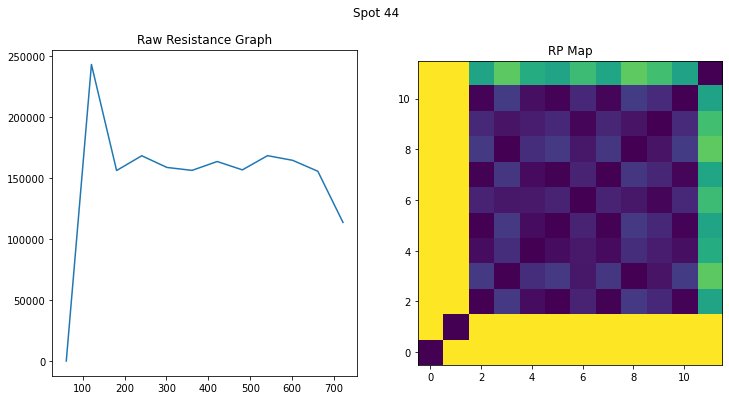

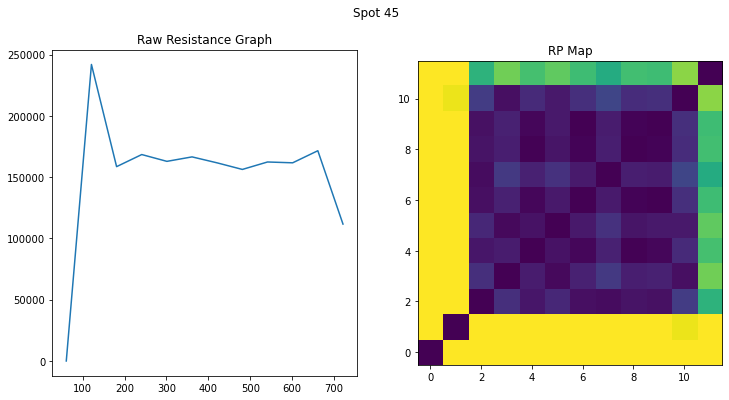

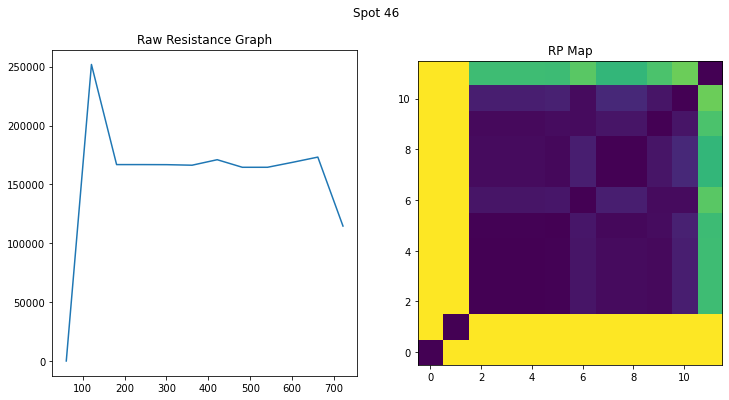

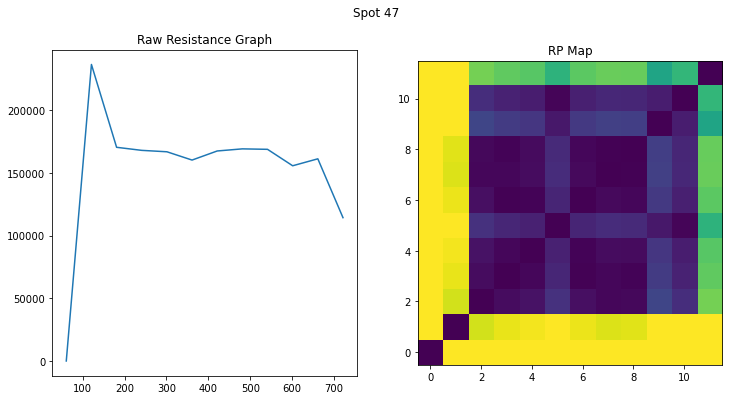

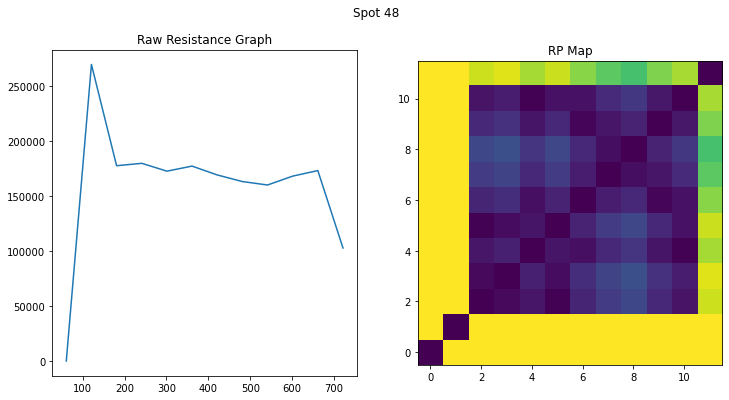

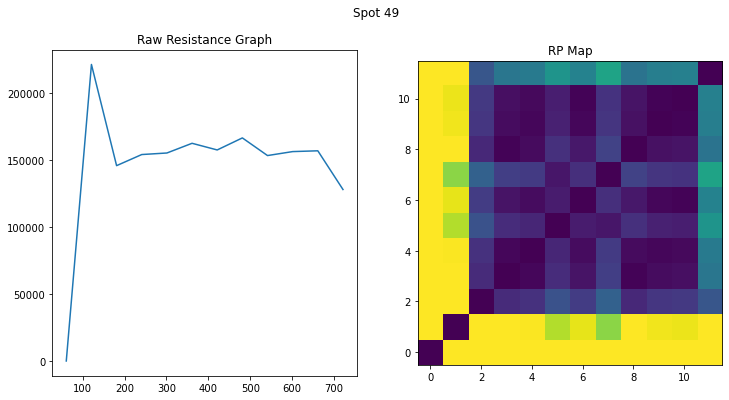

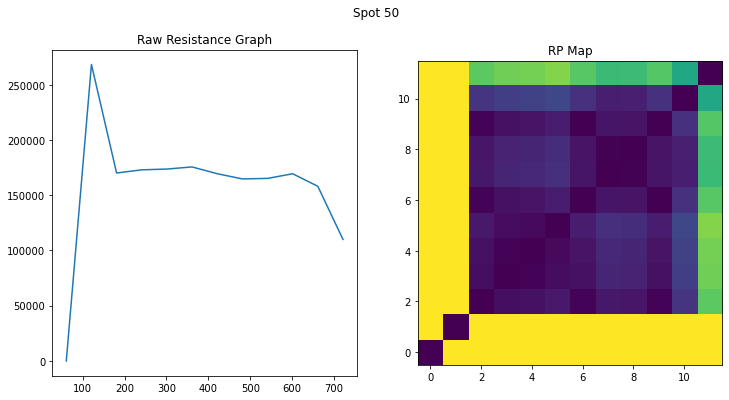

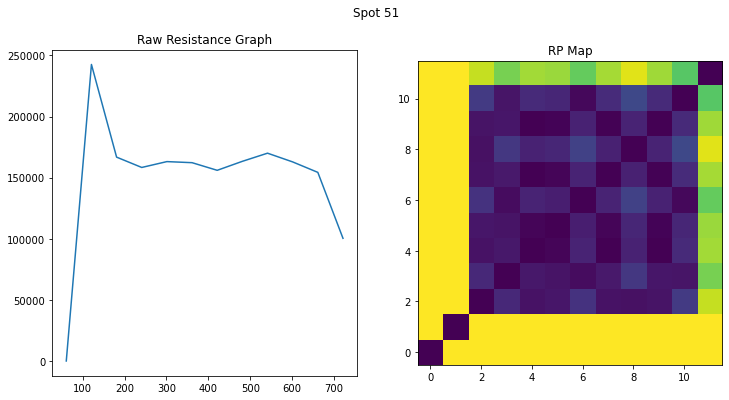

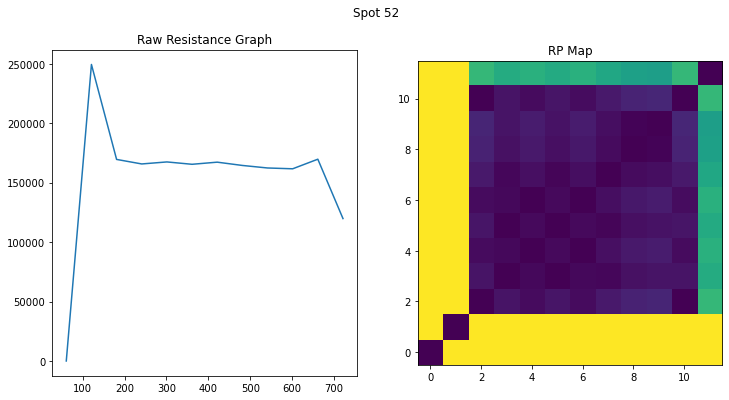

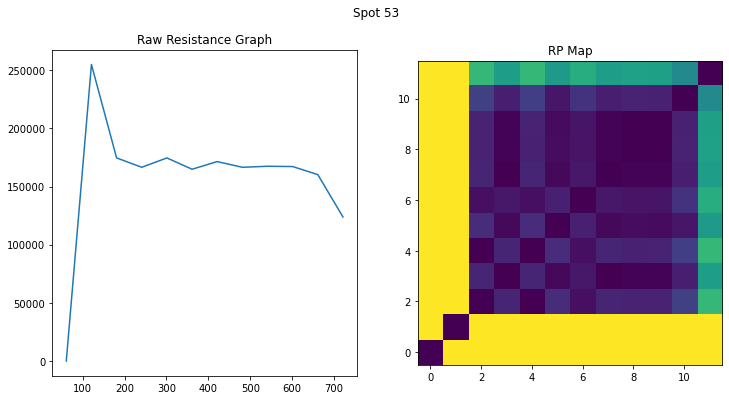

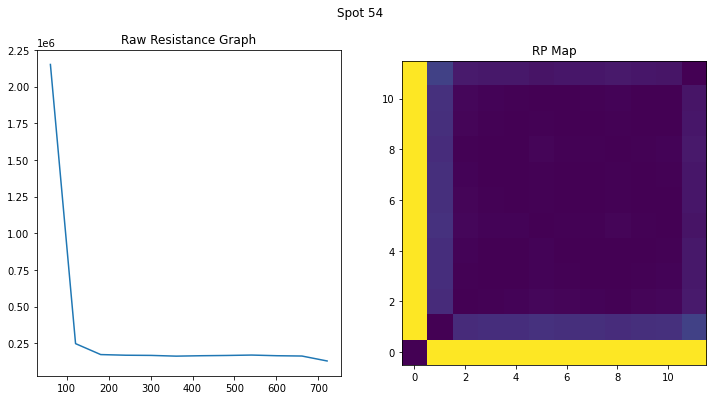

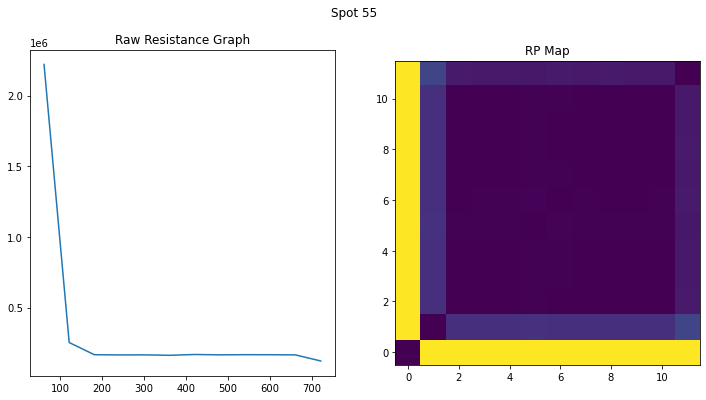

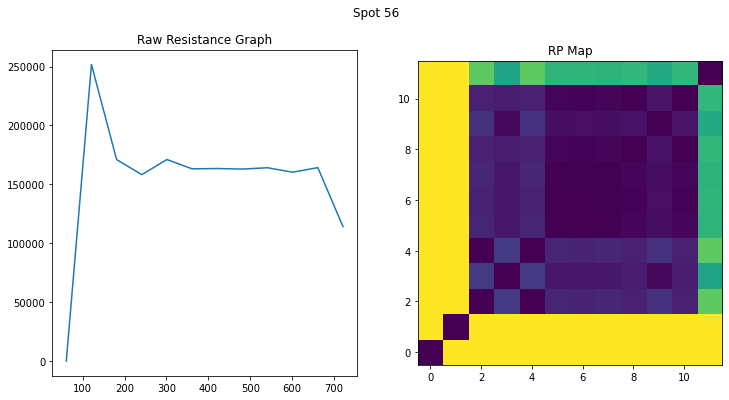

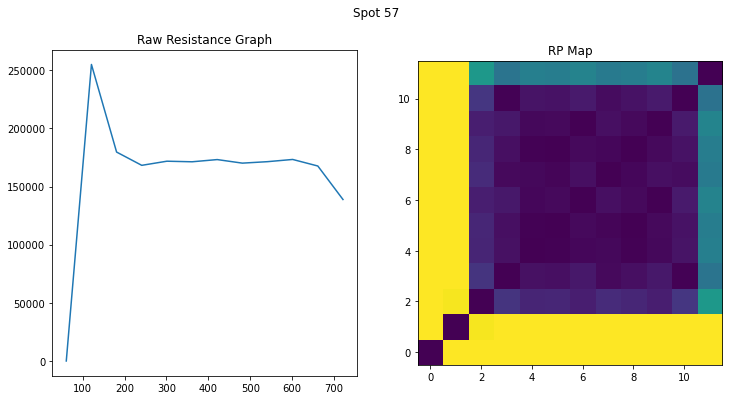

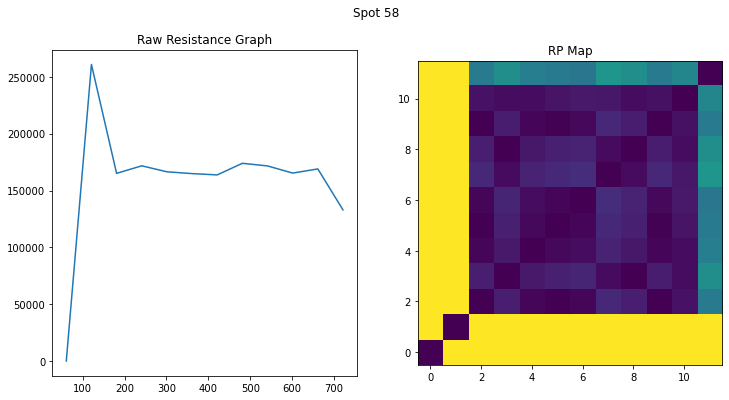

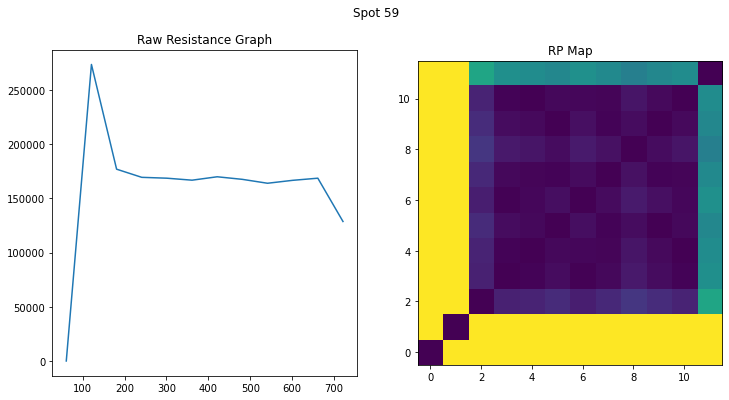

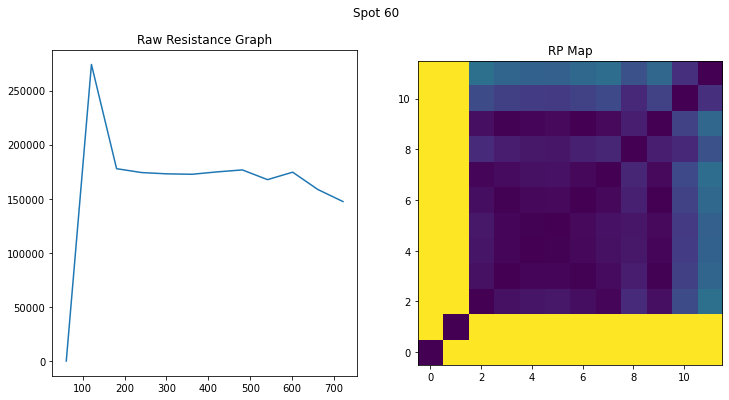

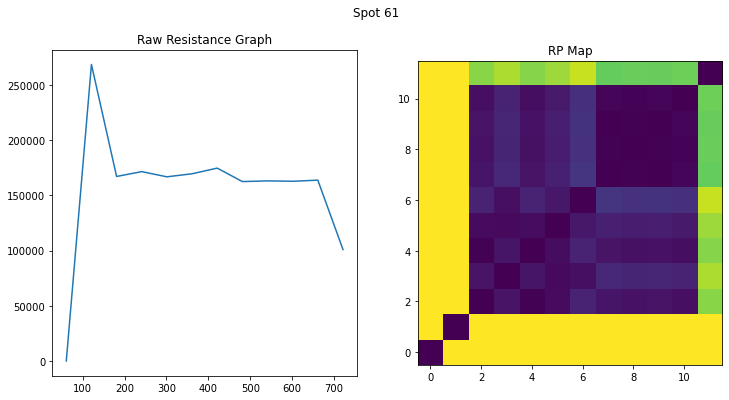

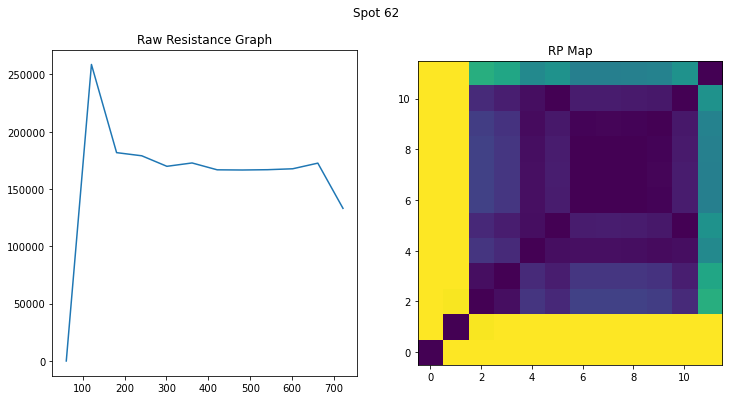

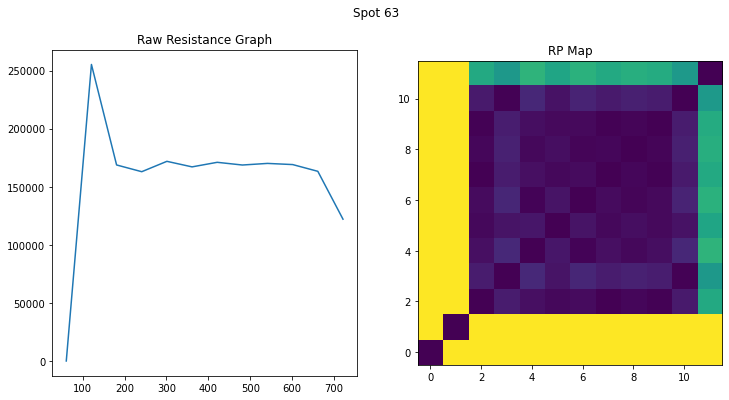

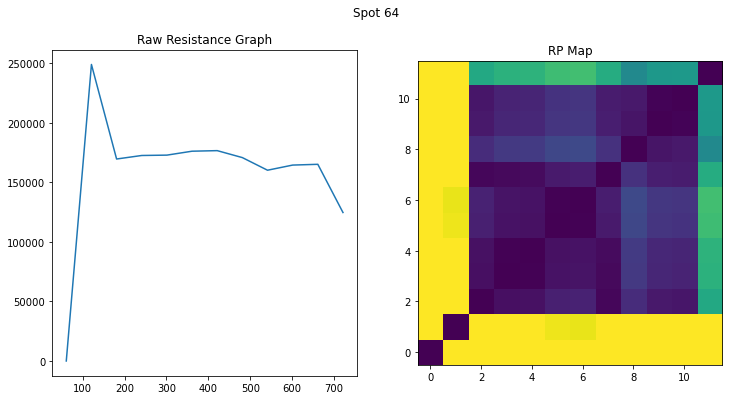

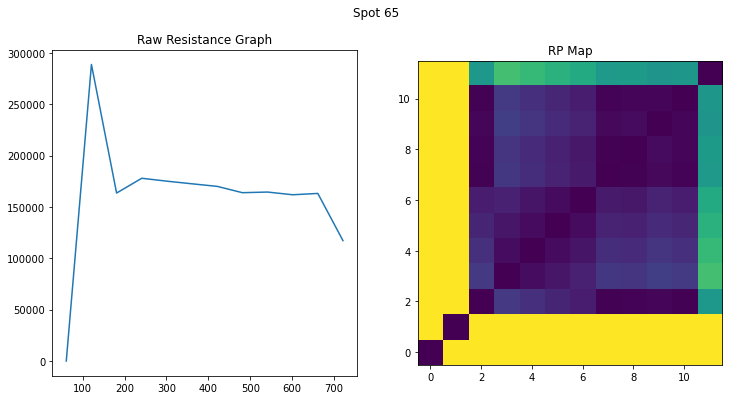

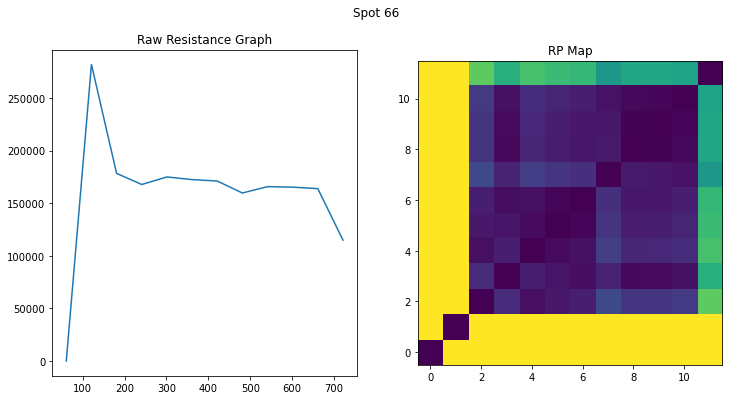

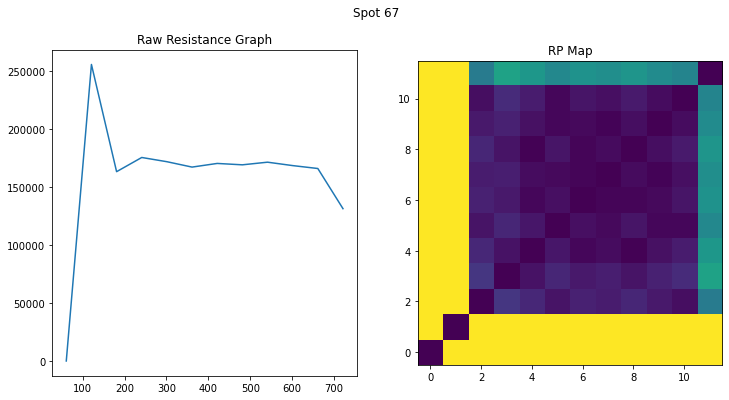

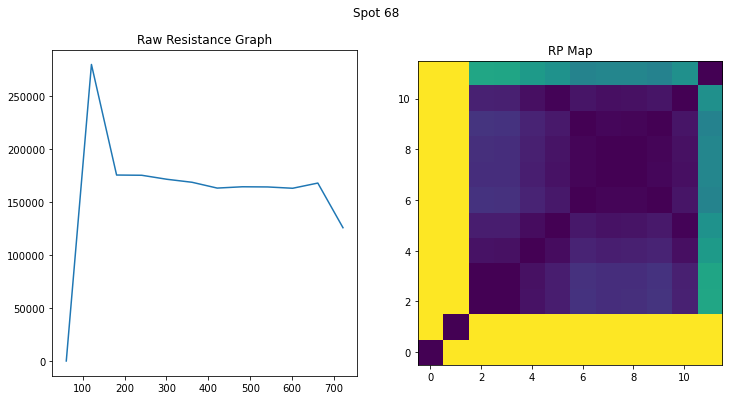

In [85]:
for i in range(1,69):
    data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
    time=np.arange(60,765,60)
    df=pre_process(data_path=data_path,timestamps=time)
    rp_mat=get_rp_matrix(signal_values=df["Resistance (Ohm)"])
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spot {i}')
    plt.subplot(1,2,1)
    plt.title('Raw Resistance Graph')
    plt.plot(df["Time"],df["Resistance (Ohm)"])
    plt.subplot(1,2,2)
    plt.title("RP Map")
    plt.imshow(rp_mat,cmap='viridis',origin='lower')
    plt.savefig(rf'Sensor Data Analysis\RP_PaperReplication\{i}.jpg',format='jpg',dpi=300)

In [18]:
peak_time1=df1["Resistance (Ohm)"].argmax()+61
peak_time11=df11["Resistance (Ohm)"].argmax()+61
peak_time24=df24["Resistance (Ohm)"].argmax()+61
peak_time28=df28["Resistance (Ohm)"].argmax()+61
peak_time34=df34["Resistance (Ohm)"].argmax()+61
peak_time50=df50["Resistance (Ohm)"].argmax()+61
peak_time67=df67["Resistance (Ohm)"].argmax()+61

print("Intial squeeze time was 60 ms, then 50ms 6kA Current then 600ms 12kA current then again 50ms for 6kA current")
print(f"\nThe time taken to reach the peak for spot 1 : {peak_time1} ")
print(f"\nThe time taken to reach the peak for spot 11 : {peak_time11} ")
print(f"\nThe time taken to reach the peak for spot 24 : {peak_time24} ")
print(f"\nThe time taken to reach the peak for spot 28 : {peak_time28} ")
print(f"\nThe time taken to reach the peak for spot 34 : {peak_time34} ")
print(f"\nThe time taken to reach the peak for spot 50 : {peak_time50} ")
print(f"\nThe time taken to reach the peak for spot 67 : {peak_time67} ")

Intial squeeze time was 60 ms, then 50ms 6kA Current then 600ms 12kA current then again 50ms for 6kA current

The time taken to reach the peak for spot 1 : 61 

The time taken to reach the peak for spot 11 : 61 

The time taken to reach the peak for spot 24 : 61 

The time taken to reach the peak for spot 28 : 61 

The time taken to reach the peak for spot 34 : 61 

The time taken to reach the peak for spot 50 : 61 

The time taken to reach the peak for spot 67 : 61 


Text(0.5, 1.0, 'Resistance Curves during Welding Time')

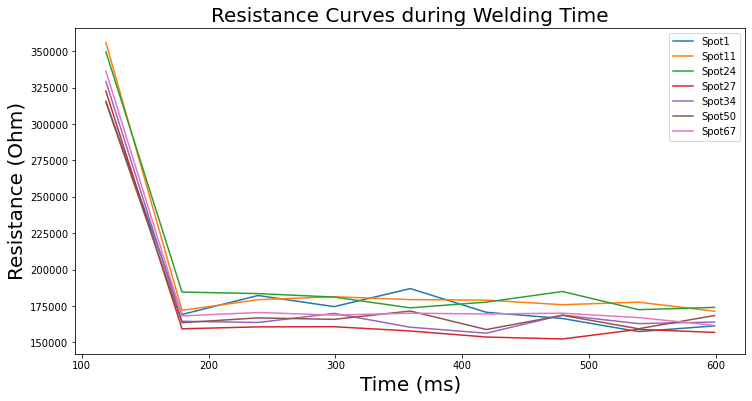

In [11]:
plt.figure(figsize=(12,6))


plt.plot(df1["Time"],df1["Resistance (Ohm)"],label='Spot1')
plt.plot(df11["Time"],df11["Resistance (Ohm)"],label='Spot11')
plt.plot(df24["Time"],df24["Resistance (Ohm)"],label='Spot24')
plt.plot(df27["Time"],df27["Resistance (Ohm)"],label='Spot27')
# plt.plot(df28["Time"],df28["Resistance (Ohm)"],label='Spot28')
plt.plot(df34["Time"],df34["Resistance (Ohm)"],label='Spot34')
plt.plot(df50["Time"],df50["Resistance (Ohm)"],label='Spot50')
plt.plot(df67["Time"],df67["Resistance (Ohm)"],label='Spot67')
plt.legend()
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Resistance Curves during Welding Time",fontsize=20)


In [33]:
dfs=[]
for i in range(1,69):
    path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
    dfi=pre_process(data_path=path,timestamps=time)
    dfs.append(dfi)




In [85]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    
    return dtw_matrix[n, m]

def compute_shape_factors(resistance_series):
    scaler = MinMaxScaler()
    resistance_series_norm = [
        scaler.fit_transform(df["Resistance (Ohm)"].values.reshape(-1, 1)).flatten()
        for df in resistance_series
    ]

    reference = resistance_series_norm[0]
    shape_factors = [dtw_distance(reference, series) for series in resistance_series_norm]

    return shape_factors

In [122]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],      # insertion
                dtw_matrix[i, j-1],      # deletion
                dtw_matrix[i-1, j-1]     # match
            )
    return dtw_matrix[n, m]

def compute_shape_factors_consecutive(resistance_series):
    scaler = MinMaxScaler()
    resistance_series_norm = [
        scaler.fit_transform(df["Resistance (Ohm)"].values.reshape(-1, 1)).flatten()
        for df in resistance_series
    ]

    shape_factors = [0]  # First spot has no previous spot to compare with

    for i in range(1, len(resistance_series_norm)):
        distance = dtw_distance(resistance_series_norm[i-1], resistance_series_norm[i])
        shape_factors.append(distance)

    return shape_factors


In [123]:
shape_factors=compute_shape_factors_consecutive(dfs)

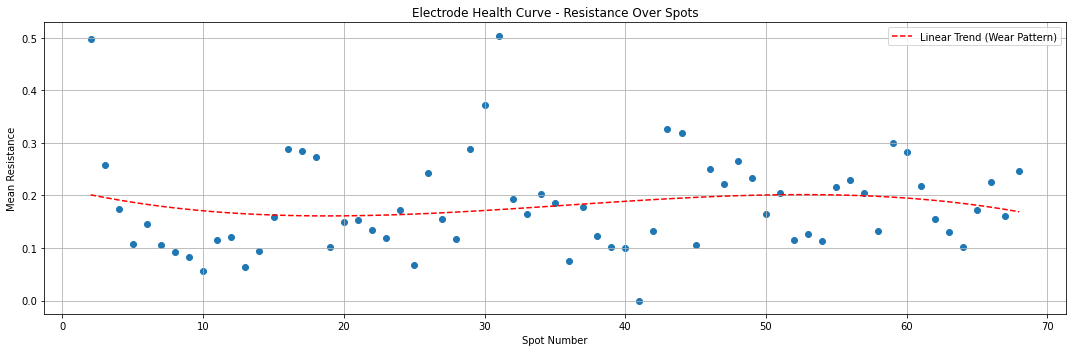

In [144]:
spots=np.arange(2,69,1)

x = spots
y = shape_factors[1:]

# Linear trendline
coeffs = np.polyfit(x, y, deg=3)
trendline = np.polyval(coeffs, x)

# Plot
plt.figure(figsize=(15, 5))
plt.scatter(x, y)
plt.plot(x, trendline, 'r--', label='Linear Trend (Wear Pattern)')
plt.title('Electrode Health Curve - Resistance Over Spots')
plt.xlabel('Spot Number')
plt.ylabel('Mean Resistance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[0.49840881244357194, 0.2576775073748542, 0.17507054673261524, 0.10852868342154753, 0.14616167697099647, 0.10586204224007512, 0.0928734644084408, 0.08355464270495905, 0.05713598702431677, 0.11510719047573281, 0.12141549241389016, 0.06304450391427208, 0.093589705429731, 0.1584827273237619, 0.28936210332990786, 0.2839392435765795, 0.272460280352385, 0.10152819479468456, 0.14991322199835033, 0.1533413639387493, 0.13523369009744934, 0.11957655224769137, 0.17157904642767807, 0.06789106295914193, 0.24209363367236691, 0.15447244585770914, 0.11778331560425515, 0.2880531806136395, 0.3721058738169869, 0.5042638430724566, 0.19426362144896414, 0.16387459057295228, 0.20201972642074062, 0.18497199453438795, 0.0751484679232639, 0.17850476153989936, 0.12275922253988447, 0.10153814615915913, 0.09919897678753564, 0.0, 0.1330169328219033, 0.32629816512731535, 0.319359045860778, 0.10480734717078133, 0.25079684079150266, 0.22129743775676936, 0.2665870367131178, 0.23246657144745742, 0.16485349903662594, 0.2

<Figure size 864x360 with 0 Axes>

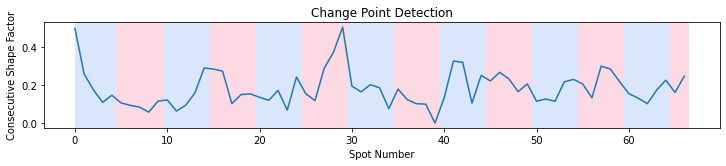

Detected change points at spot indices: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 67]


In [145]:
import ruptures as rpt

# Signal = 1D array of mean resistances
signal = np.array(y)
print(y)
# Use Pelt or Binary Segmentation
model = "rbf"  # or "l2" depending on data behavior
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=0.01)  # Try tuning 'pen'

# Plot
plt.figure(figsize=(12,5))
rpt.display(signal, result)
plt.title("Change Point Detection")
plt.xlabel("Spot Number")
plt.ylabel("Consecutive Shape Factor")
plt.show()

# Change points will mark spots where shift occurred
change_points = result
print("Detected change points at spot indices:", change_points)

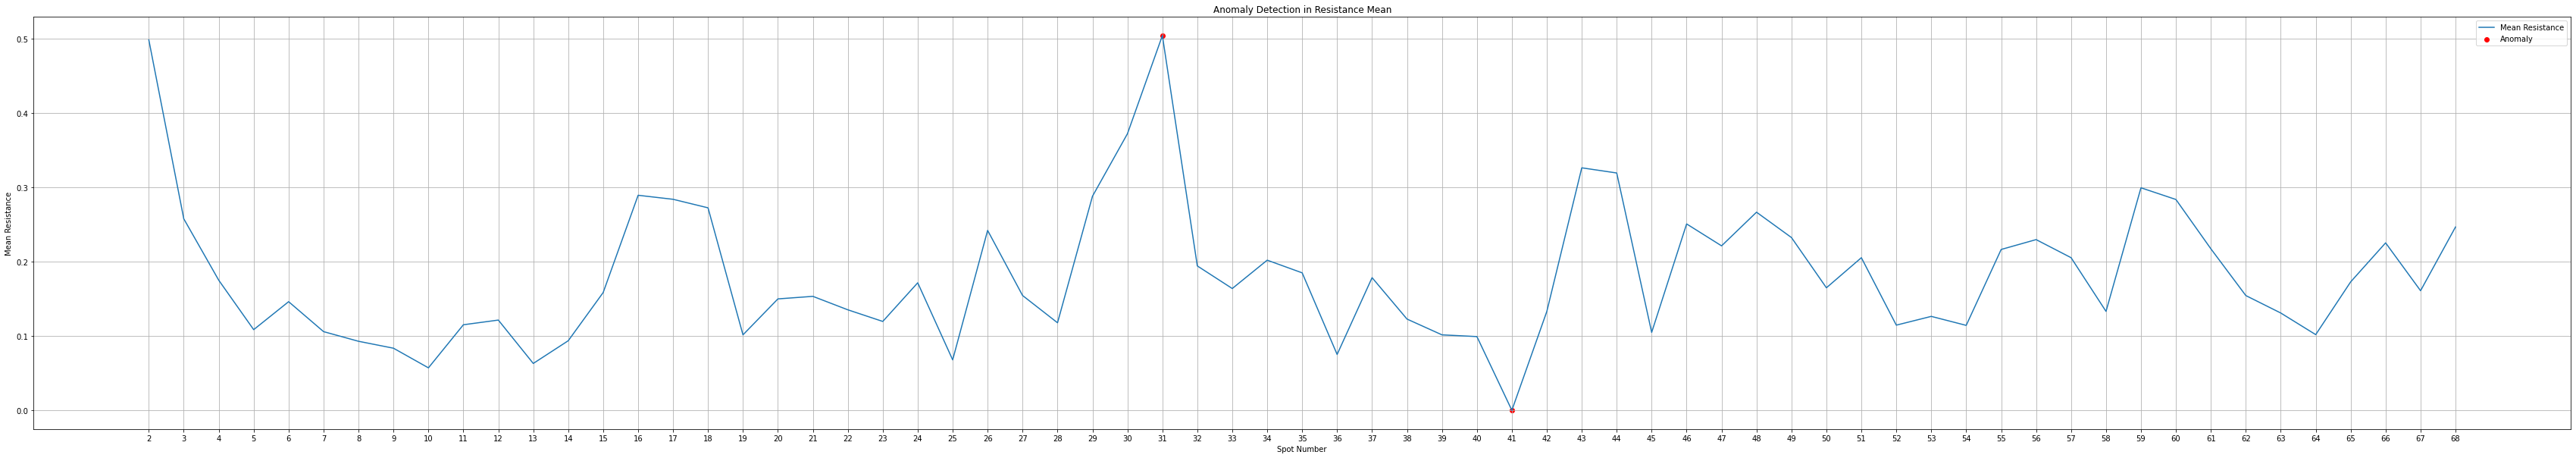

Anomalous spots: [31, 41]


In [149]:
resistance_means=shape_factors[1:]
spot_numbers=df_Resistance.index.values[1:]

X = np.array(resistance_means).reshape(-1, 1)  # Mean resistance

# Train anomaly detector
iso = IsolationForest(contamination=0.02)  # 5% expected anomalies
labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot
plt.figure(figsize=(60, 10))
plt.plot(spot_numbers, resistance_means, label='Mean Resistance')
plt.scatter(np.array(spot_numbers)[labels == -1],
            np.array(resistance_means)[labels == -1],
            color='red', label='Anomaly')
plt.xlabel("Spot Number")
plt.ylabel("Mean Resistance")

plt.xticks(spot_numbers)
plt.legend()
plt.title("Anomaly Detection in Resistance Mean")
plt.grid(True)
plt.show()

# Get detected anomalous spots
anomalous_spots = [spot for spot, label in zip(spot_numbers, labels) if label == -1]
print("Anomalous spots:", anomalous_spots)